# Load and install all dependicies

In [2]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 798.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
!wandb login de83b34df4865f6d73caa690771345a92e44bb2d

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [4]:
!git clone https://github.com/OscarOvanger/GeoDecepticon.git

Cloning into 'GeoDecepticon'...
remote: Enumerating objects: 20266, done.
remote: Counting objects: 100% (328/328), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 20266 (delta 259), reused 171 (delta 171), pack-reused 19938 (from 5)
Receiving objects: 100% (20266/20266), 162.35 MiB | 10.09 MiB/s, done.
Resolving deltas: 100% (563/563), done.
Updating files: 100% (83/83), done.


In [5]:
import os
os.chdir('/content/GeoDecepticon')

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import wandb
import os
from tqdm.notebook import tqdm
import copy
from ViT import *
from ViT_sampling import *
from training import *
#from sampling import *
from tqdm import tqdm  # For progress bars
import time

# Load and plot training data

(9000, 64, 64)


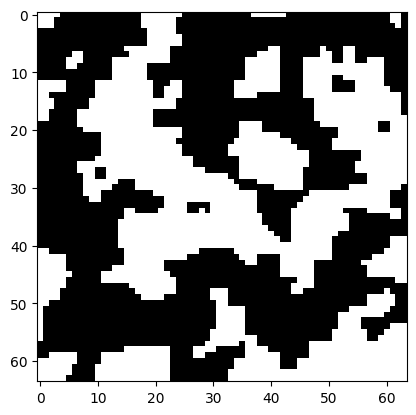

In [7]:
arr = np.load("Data/Markov_field/training_data_mod.npz")["arr_0"]
training_data = arr[:9000]
test_data = arr[9000:]
# We reshape it to 60x60 dataset
training_data = training_data.reshape(-1, 64, 64)
test_data = test_data.reshape(-1, 64, 64)
print(training_data.shape)
training_data = torch.tensor(training_data,dtype=torch.float32)
sanity_check_data = training_data[:10]
test_data = torch.tensor(test_data,dtype=torch.float32)
#plot the first data
plt.imshow(training_data[100],cmap='gray')
plt.show()

# Condition data

In [8]:
"""
condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,
                                2000,3312,2953,289,2373,2720,872,2713,1206,1341,
                                3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,
                              1,1,1,0,1,0,1,1,0,1])
condition_indices_x = condition_indices // 64
condition_indices_y = condition_indices % 64
print(condition_indices_x)
print(condition_indices_y)
plt.imshow(training_data[0],cmap='gray')
plt.scatter(condition_indices_y,condition_indices_x,c=condition_values,cmap='viridis')
plt.show()
"""

"\ncondition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,\n                                2000,3312,2953,289,2373,2720,872,2713,1206,1341,\n                                3541,2226,3423,1904,2882,2540,1497,2524,264,1441])\ncondition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,\n                              1,1,1,0,1,0,1,1,0,1])\ncondition_indices_x = condition_indices // 64\ncondition_indices_y = condition_indices % 64\nprint(condition_indices_x)\nprint(condition_indices_y)\nplt.imshow(training_data[0],cmap='gray')\nplt.scatter(condition_indices_y,condition_indices_x,c=condition_values,cmap='viridis')\nplt.show()\n"

[13 39 44 48 41 33 15 17 47 16 18 46  4 42 28]
[38 29 43 55 25 59 49  7 16 14 20 22 51 60 23]


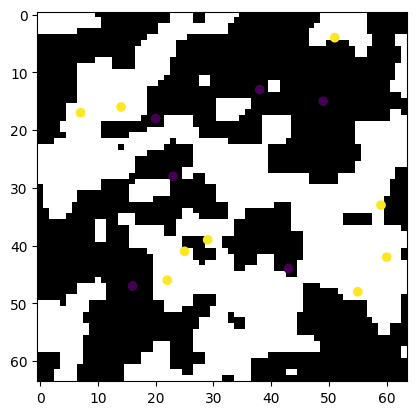

In [9]:
condition_indices_new = np.array([1726,3797,4211,4543,3953,3347,1897,2015,4424,1942,2108,4350,1019,4068,2911])
condition_values_new = np.array([0,1,0,1,1,1,0,1,0,1,0,1,1,1,0])
condition_indices_x = (condition_indices_new // 80) - 8
condition_indices_y = (condition_indices_new % 80) - 8
print(condition_indices_x)
print(condition_indices_y)
cond_data = np.load("Data/Markov_field/training_data_mod_cond.npz")["arr_0"]
plt.imshow(cond_data[105],cmap='gray')
plt.scatter(condition_indices_y,condition_indices_x,c=condition_values_new,cmap='viridis')
plt.show()

# Train Model

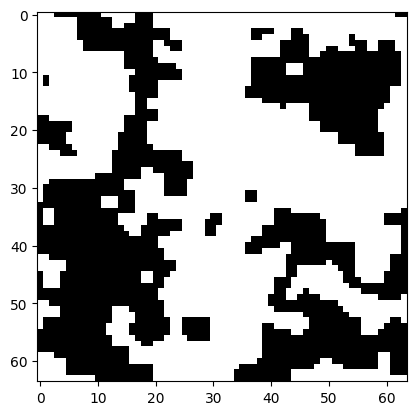

In [10]:
samps = np.load("cond_images_combined.npy")
plt.imshow(samps[0],cmap='gray')
plt.show()

In [11]:
# Try training for, say, 500 epochs; you can also try mask_rate=1.0 for a stricter overfit test.
nr_epochs = 1000
batch_size = 100
mask_rate = 0.05  # Try also mask_rate = 1.0 to check if the network can memorize given only positional cues.
final_mask_rate = 0.95
mask_schedule = "exp"
patch_size = 4
num_heads = 2
num_layers = 2
ffn_dim = 256
emb_dim = 64
learning_rate = 1e-3
vocab_cap = 100000
"""
trained_model = run_training(training_data, nr_epochs, batch_size, mask_rate, final_mask_rate, mask_schedule, patch_size,
                             num_heads, num_layers, ffn_dim, learning_rate, emb_dim, vocab_cap)
"""

'\ntrained_model = run_training(training_data, nr_epochs, batch_size, mask_rate, final_mask_rate, mask_schedule, patch_size,\n                             num_heads, num_layers, ffn_dim, learning_rate, emb_dim, vocab_cap)\n'

In [12]:
import torch

ckpt_path = "Models/BEST_MODEL.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")

print("=== CHECKPOINT PARAMS ===")
for k, v in ckpt.items():
    # some entries in a checkpoint might be nested dicts (e.g. optimizer states)
    # we only want the tensors, so check isinstance(v, torch.Tensor)
    if isinstance(v, torch.Tensor):
        print(f"{k:40s}  {tuple(v.shape)}  dtype={v.dtype}")
    else:
        print(f"{k:40s}  (type={type(v)})")

=== CHECKPOINT PARAMS ===
mask_token                                (16,)  dtype=torch.float32
rel_bias_table                            (31, 31)  dtype=torch.float32
pos_emb                                   (1,)  dtype=torch.float32
patch_proj.weight                         (64, 16)  dtype=torch.float32
patch_proj.bias                           (64,)  dtype=torch.float32
layers.0.attn.in_proj_weight              (192, 64)  dtype=torch.float32
layers.0.attn.in_proj_bias                (192,)  dtype=torch.float32
layers.0.attn.out_proj.weight             (64, 64)  dtype=torch.float32
layers.0.attn.out_proj.bias               (64,)  dtype=torch.float32
layers.0.norm1.weight                     (64,)  dtype=torch.float32
layers.0.norm1.bias                       (64,)  dtype=torch.float32
layers.0.ffn.0.weight                     (256, 64)  dtype=torch.float32
layers.0.ffn.0.bias                       (256,)  dtype=torch.float32
layers.0.ffn.3.weight                     (64, 256)  dtype=

In [13]:
# Assume training_data is already defined with shape (N, H, W)
N, H, W = training_data.shape

# Set parameters.
vocab, counts, mask_token = build_vocabulary(training_data, patch_size, cap_size=vocab_cap)
patch_dim = patch_size ** 2
num_patches = (H // patch_size) ** 2

#samps = torch.tensor(samps,dtype=torch.float32)

flattened_condition_indices = np.zeros(len(condition_indices_new))
for i in range(len(condition_indices_new)):
    flattened_condition_indices[i] = condition_indices_x[i] * 64 + condition_indices_y[i]
flattened_condition_indices = flattened_condition_indices.astype(int)

# Create the model and load weights.
PATH = "Models/BEST_MODEL.pth"
model = StackedContextViT(
    vocab=vocab,
    mask_token=mask_token,
    patch_dim=patch_dim,
    num_patches=num_patches,
    emb_dim=emb_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    ffn_dim=ffn_dim,
    use_pos_emb=False,          # <— must be True to load the old 256×64 buffer
    use_rel_bias=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(PATH, map_location=device))  # remove weights_only if not applicable
"""
model.to(device)
model.vocab = model.vocab.to(device)
model.mask_token = model.mask_token.to(device)
images,ll = generate_images_batch(model, patch_size, image_size=H, batch_size=3,device=device,
                          condition_indices=flattened_condition_indices, condition_values=condition_values_new,
                          generation_order="manhattan")
plt.imshow(images[0],cmap='gray')
plt.title(f"ll: {ll[0]}")
plt.show()
images = images.to(device)
ll_new = log_likelihood_evaluation_batch(
    model,
    images,            # tensor [B, H, W] of binary images
    patch_size,              # int
    condition_indices=flattened_condition_indices,
    condition_values=condition_values_new,
    generation_order="manhattan"
)
print(f"ll_new: {ll_new[0]}")
samps = samps.to(device)
ll_VEA_full = []
for i in range(30):
  ll_VEA = log_likelihood_evaluation_batch(
      model,
      samps[i*100:(i+1)*100],            # tensor [B, H, W] of binary images
      patch_size,              # int
      condition_indices=flattened_condition_indices,
      condition_values=condition_values_new,
      generation_order="manhattan"
  )
  ll_VEA_full.append(ll_VEA)
print(ll_VEA)
"""

'\nmodel.to(device)\nmodel.vocab = model.vocab.to(device)\nmodel.mask_token = model.mask_token.to(device)\nimages,ll = generate_images_batch(model, patch_size, image_size=H, batch_size=3,device=device, \n                          condition_indices=flattened_condition_indices, condition_values=condition_values_new, \n                          generation_order="manhattan")\nplt.imshow(images[0],cmap=\'gray\')\nplt.title(f"ll: {ll[0]}")\nplt.show()\nimages = images.to(device)\nll_new = log_likelihood_evaluation_batch(\n    model,\n    images,            # tensor [B, H, W] of binary images\n    patch_size,              # int\n    condition_indices=flattened_condition_indices,\n    condition_values=condition_values_new,\n    generation_order="manhattan"\n)\nprint(f"ll_new: {ll_new[0]}")\nsamps = samps.to(device)\nll_VEA_full = []\nfor i in range(30):\n  ll_VEA = log_likelihood_evaluation_batch(\n      model,\n      samps[i*100:(i+1)*100],            # tensor [B, H, W] of binary images\n    

In [14]:
import math
import torch
import torch.nn.functional as F

def compute_log_likelihood_batch(
    model,
    device,
    image_batches,
    condition_indices=None,
    condition_values=None,
    generation_order="manhattan",
    atol=1e-6
):
    """
    Compute sum of log-likelihoods for a batch of fully-observed images under
    the masked‐patch sequential model, following the specified generation_order.

    Args:
        model:            PyTorch model with attributes
                          - .vocab       (Tensor[V, D])
                          - .mask_token  (Tensor[D])
                          and callable forward(inputs, mask_rate=0.0) -> (logits, _)
        device:           torch device (e.g. "cuda")
        image_batches:    FloatTensor of shape [B, H, W], values in [0,1]
        condition_indices: List of flattened pixel indices to treat as
                           additional observed constraints (shared across batch)
        condition_values:  List of 0/1 values for those indices
        generation_order:  One of "raster", "manhattan", "inverse manhattan"
        atol:             Tolerance for matching patch vectors to vocab

    Returns:
        log_likelihoods:  FloatTensor of shape [B], sum of per-patch log-probs
    """
    model.to(device)
    model.eval()
    image_batches = image_batches.to(device)
    B, H, W = image_batches.shape
    # infer patch size & grid
    D = model.mask_token.shape[0]
    P = int(math.sqrt(D))
    assert P*P == D, "mask_token dim not a square"
    assert H == W and H % P == 0, "image size must be divisible by patch_size"
    G = H // P
    T = G * G

    # pull out true patch vectors: [B, T, D]
    patches = (
        image_batches
        .unfold(1, P, P)          # -> [B, G, W, P]
        .unfold(2, P, P)          # -> [B, G, G, P, P]
        .permute(0,1,2,3,4)       # ensure layout
        .contiguous()
        .view(B, T, D)
    )

    # build patch-level condition map
    conditions_by_patch = {}
    if condition_indices is not None and condition_values is not None:
        for pix_idx, pix_val in zip(condition_indices, condition_values):
            pr, pc = divmod(pix_idx, H)
            pr0, pc0 = pr // P, pc // P
            pidx = pr0 * G + pc0
            local = (pr % P)*P + (pc % P)
            conditions_by_patch.setdefault(pidx, []).append((local, pix_val))

    # figure out sampling order
    observed = sorted(conditions_by_patch.keys())
    all_p   = set(range(T))
    unobs   = list(all_p - set(observed))

    if generation_order == "raster":
        unobs.sort()
    elif generation_order == "manhattan":
        if observed:
            dist = []
            for p in unobs:
                r,c = divmod(p, G)
                s = sum(abs(r - (o//G)) + abs(c - (o%G)) for o in observed)
                dist.append((p,s))
            unobs = [p for p,_ in sorted(dist, key=lambda x: x[1])]
        else:
            unobs.sort()
    elif generation_order == "inverse manhattan":
        if observed:
            inv = []
            for p in unobs:
                r,c = divmod(p, G)
                s = sum(1.0/(abs(r-(o//G))+abs(c-(o%G))) for o in observed)
                inv.append((p,s))
            unobs = [p for p,_ in sorted(inv, key=lambda x: x[1], reverse=True)]
        else:
            unobs.sort()
    else:
        raise ValueError(f"Unknown generation_order {generation_order}")

    sampling_order = observed + unobs

    # prepare storage
    log_likes = torch.zeros(B, device=device)
    mask_tok  = model.mask_token.detach().to(device)      # [D]
    vocab     = model.vocab.to(device)                    # [V, D]
    V         = vocab.shape[0]

    # initially mask all patches
    generated = mask_tok.unsqueeze(0).unsqueeze(0)\
                   .expand(B, T, D).clone()

    # sequentially fill in actual patches, accumulating log‐probs
    for p in sampling_order:
        with torch.no_grad():
            logits_full, _ = model(generated.to(device), mask_rate=0.0)
        # logits for this patch: [B, V]
        logits_p = logits_full[:, p, :]

        # apply any patch‐level condition constraints
        if p in conditions_by_patch:
            valid = torch.ones(V, dtype=torch.bool, device=device)
            for local_i, val in conditions_by_patch[p]:
                valid &= (vocab[:, local_i] == val)
            logits_p = logits_p.masked_fill(~valid.unsqueeze(0), -float('inf'))

        # compute probabilities
        probs_p = F.softmax(logits_p, dim=-1)  # [B, V]

        # find the true token index for each image in batch
        # compare vocab rows to the true patch vector
        # -> [B, V, D] difference, then match along D
        diff    = vocab.unsqueeze(0) - patches[:, p, :].unsqueeze(1)  # [B, V, D]
        matches = torch.all(torch.abs(diff) < atol, dim=2)           # [B, V]
        # argmax gives first True index (we assume every patch is in vocab)
        true_idx = matches.float().argmax(dim=1)                      # [B]

        # gather the probability assigned to the true token, accumulate
        p_true = probs_p[torch.arange(B, device=device), true_idx]
        log_likes += torch.log(p_true + 1e-10)

        # now “fill in” that patch with the true vocab vector
        generated[:, p, :] = vocab[true_idx]

    return log_likes

In [15]:
cond_data[0] == samps[0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

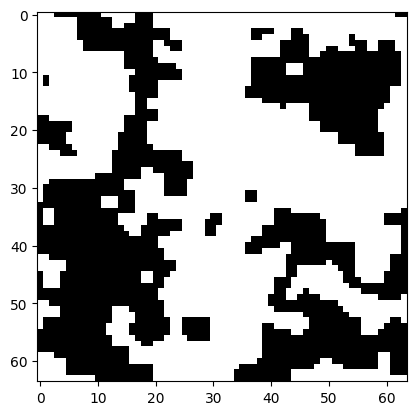

In [16]:
plt.imshow(samps[0],cmap="gray")
plt.show()

In [17]:
log_lik_list = []
for i in range(30):
  curr_batch = samps[i*100:(i+1)*100]
  curr_batch = torch.tensor(curr_batch,dtype=torch.float32).to(device)
  log_lik = compute_log_likelihood_batch(
      model,
      device,
      curr_batch,
      condition_indices=flattened_condition_indices,
      condition_values=condition_values_new,
      generation_order="manhattan",
      atol=1e-6
  )
  log_lik_list.append(log_lik)
print(log_lik_list)
# Convert to numpy array
log_lik_array = np.array(log_lik_list)
# save numpy array
np.save("log_lik_array.npy", log_lik_array)

[tensor([-804.9146, -798.7664, -775.2332, -796.5264, -870.2641, -816.8688,
        -887.6250, -812.3987, -775.7068, -883.1868, -783.9315, -772.6533,
        -767.4265, -786.2260, -901.8624, -811.5241, -832.4752, -823.0953,
        -837.9073, -767.0562, -846.2405, -777.8098, -835.7910, -701.5386,
        -796.7508, -802.4155, -877.0087, -837.5852, -830.0040, -830.2473,
        -850.5096, -821.0628, -835.0541, -814.2245, -811.6360, -804.0234,
        -903.5063, -782.1427, -788.9658, -803.7610, -894.8716, -798.3705,
        -804.8395, -693.7713, -727.4835, -821.1485, -703.0692, -826.7627,
        -871.6981, -821.8534, -783.5390, -827.2867, -851.4584, -830.6038,
        -836.2922, -731.7023, -900.3409, -773.4166, -865.1140, -866.7017,
        -890.6581, -804.7090, -796.7369, -745.8907, -833.7115, -819.3760,
        -771.1551, -867.5062, -750.6920, -759.1204, -736.2361, -868.9527,
        -911.4882, -802.9187, -832.1390, -737.0582, -842.7597, -844.0649,
        -853.5861, -750.1581, -803.11

In [18]:
np.array([log_lik_list[i].cpu().detach().numpy() for i in range(30)])

array([[ -804.9146 ,  -798.7664 ,  -775.23315, ...,  -739.599  ,
         -839.8479 ,  -724.10974],
       [ -797.15564,  -843.0793 ,  -820.46295, ...,  -833.7951 ,
         -770.5236 ,  -765.0194 ],
       [ -811.50995,  -872.36273,  -829.8123 , ...,  -832.35187,
         -831.2683 ,  -852.1915 ],
       ...,
       [ -992.8946 , -1037.2747 , -1086.9882 , ..., -1009.99854,
         -985.7914 ,  -997.6176 ],
       [-1032.5293 ,  -979.51184, -1062.2701 , ...,  -998.638  ,
        -1046.6824 ,  -920.6092 ],
       [ -997.5521 ,  -986.98425, -1002.7961 , ..., -1070.5112 ,
        -1081.319  , -1019.8106 ]], dtype=float32)

In [22]:
model.to(device)
model.vocab = model.vocab.to(device)
model.mask_token = model.mask_token.to(device)
reverse_manhattan_images = []
reverse_manhattan_lls = []
for i in range(10):
  images,ll = generate_images_batch(model, patch_size, image_size=H, batch_size=100,device=device,
                          condition_indices=flattened_condition_indices, condition_values=condition_values_new,
                          generation_order="inverse manhattan")
  images = images.cpu().detach().numpy()
  reverse_manhattan_images.append(images)
  reverse_manhattan_lls.append(ll)

In [24]:
reverse_manhattan_images = np.concatenate(reverse_manhattan_images,axis=0)
reverse_manhattan_lls = np.concatenate(reverse_manhattan_lls,axis=0)

In [30]:
np.save("reverse_manhattan_images.npy",reverse_manhattan_images)
np.save("reverse_manhattan_lls.npy",reverse_manhattan_lls)

In [65]:
import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
import imageio

def add_colored_border(token, border_width=1, border_color=(1, 0, 0)):
    token_rgb = np.stack([token]*3, axis=-1)
    H, W, _ = token_rgb.shape
    new_H, new_W = H+2*border_width, W+2*border_width
    bordered = np.ones((new_H, new_W, 3))*0.5
    bordered[border_width:border_width+H, border_width:border_width+W] = token_rgb
    bordered[:border_width,:] = border_color
    bordered[-border_width:,:] = border_color
    bordered[:,:border_width] = border_color
    bordered[:,-border_width:] = border_color
    return bordered

def fig_to_np(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    return np.array(Image.open(buf).convert("RGB"))

def generate_video(
    model,
    patch_size,
    image_size,
    condition_indices=None,
    condition_values=None,
    topk=10,
    video_filename="generation.mp4",
    fps=4,
    generation_order="manhattan",
    given_image=None,
):
    device = next(model.parameters()).device
    model.eval()

    grid = image_size // patch_size
    T = grid * grid
    D = patch_size * patch_size
    V = model.vocab.size(0)

    # States
    mask_tok = model.mask_token.detach().to(device)
    gen_state = mask_tok.unsqueeze(0).expand(T, D).clone()
    gt_state  = mask_tok.unsqueeze(0).expand(T, D).clone()
    done = torch.zeros(T, dtype=torch.bool, device=device)

    # Extract ground-truth patches
    if given_image is not None:
        gimg = (torch.from_numpy(given_image)
                if isinstance(given_image, np.ndarray)
                else given_image).to(device)
        g_patches = []
        for p in range(T):
            r0 = (p//grid)*patch_size; c0 = (p%grid)*patch_size
            g_patches.append(gimg[r0:r0+patch_size,c0:c0+patch_size].reshape(-1))
        g_patches = torch.stack(g_patches)
    else:
        g_patches = None

    # Conditions
    conditions = {}
    if condition_indices is not None and condition_values is not None:
        for pix,val in zip(condition_indices, condition_values):
            pr,pc = divmod(pix, image_size)
            pr0,pc0 = pr//patch_size, pc//patch_size
            pidx = pr0*grid + pc0
            lidx = (pr%patch_size)*patch_size + (pc%patch_size)
            conditions.setdefault(pidx, []).append((lidx, val))

    # Sampling order
    observed = sorted(conditions.keys())
    unobs = list(set(range(T)) - set(observed))
    if generation_order == "raster":
        unobs.sort()
    elif generation_order == "manhattan":
        dist = []
        for p in unobs:
            r,c = divmod(p,grid)
            s = sum(abs(r-o//grid)+abs(c-o%grid) for o in observed)
            dist.append((p,s))
        unobs = [p for p,_ in sorted(dist, key=lambda x:x[1])]
    elif generation_order == "inverse manhattan":
        inv = []
        for p in unobs:
            r,c = divmod(p,grid)
            s = sum(1.0/(abs(r-o//grid)+abs(c-o%grid)) for o in observed)
            inv.append((p,s))
        unobs = [p for p,_ in sorted(inv, key=lambda x:x[1], reverse=True)]
    else:
        raise ValueError(f"Unknown generation_order {generation_order}")
    order = observed + unobs

    # Accumulators
    acc_ll_gen = 0.0
    acc_ll_gt  = 0.0
    mode_count_gen = 0
    mode_count_gt  = 0

    frames = []
    cmap = ListedColormap(["blue","red"])

    for step, pidx in enumerate(tqdm(order, desc="Sampling")):
        # 1) forward on generated
        with torch.no_grad():
            logits_gen,_ = model(gen_state.unsqueeze(0), mask_rate=0.0)
        probs_gen = F.softmax(logits_gen[0,pidx], dim=-1)

        # 2) forward on given
        with torch.no_grad():
            logits_gt,_  = model(gt_state.unsqueeze(0),  mask_rate=0.0)
        probs_gt  = F.softmax(logits_gt[0,pidx],  dim=-1)

        # apply conds
        if pidx in conditions:
            valid = torch.ones(V, dtype=torch.bool, device=device)
            for li,val in conditions[pidx]:
                valid &= (model.vocab[:,li]==val)
            probs_gen = probs_gen.masked_fill(~valid, 0)
            probs_gt  = probs_gt.masked_fill(~valid, 0)
            probs_gen /= probs_gen.sum()
            probs_gt  /= probs_gt.sum()

        # sample & log-likelihood
        tok_gen = torch.multinomial(probs_gen,1).item()
        llg = float(torch.log(probs_gen[tok_gen]+1e-10))
        acc_ll_gen += llg
        gen_state[pidx] = model.vocab[tok_gen]

        # mode count for gen
        mode_gen = int(torch.argmax(probs_gen).item())
        if tok_gen == mode_gen:
            mode_count_gen += 1

        # given true token
        if g_patches is not None:
            dists = ((model.vocab.to(device) - g_patches[pidx].unsqueeze(0))**2).sum(-1)
            idx_gt = int(torch.argmin(dists).item())
            llgt = float(torch.log(probs_gt[idx_gt]+1e-10))
            acc_ll_gt += llgt
            gt_state[pidx] = model.vocab[idx_gt]
            # mode count for gt
            mode_gt = int(torch.argmax(probs_gt).item())
            if idx_gt == mode_gt:
                mode_count_gt += 1
        else:
            idx_gt, llgt = None, None

        done[pidx] = True

        # topk indices & values
        topk_inds_gen = torch.topk(probs_gen, topk).indices.cpu().numpy()
        topk_vals_gen = probs_gen[topk_inds_gen].cpu().numpy()
        topk_inds_gt  = torch.topk(probs_gt,  topk).indices.cpu().numpy()
        topk_vals_gt  = probs_gt[topk_inds_gt].cpu().numpy()

        # --- 8-panel figure ---
        fig, axs = plt.subplots(1,8, figsize=(40,5))

        # Panel 1: current generated
        disp = [gen_state[i] if done[i] else torch.full((D,),0.5,device=device)
                for i in range(T)]
        img1 = patches_to_image(torch.stack(disp),(image_size,image_size),patch_size)
        axs[0].imshow(img1.cpu(), cmap="gray", vmin=0,vmax=1)
        if condition_indices is not None:
            ys = condition_indices//image_size; xs = condition_indices%image_size
            axs[0].scatter(xs,ys,c=condition_values,cmap=cmap, s=20, edgecolors="white")
        r0,c0 = (pidx//grid)*patch_size,(pidx%grid)*patch_size
        axs[0].add_patch(mpatches.Rectangle((c0-0.5,r0-0.5),
                                           patch_size,patch_size,
                                           linewidth=2, edgecolor="green",
                                           facecolor="none"))
        axs[0].set_title("Generated"); axs[0].axis("off")

        # Panel 2: given image
        if g_patches is not None:
            axs[1].imshow(gimg.cpu(), cmap="gray", vmin=0,vmax=1)
            axs[1].add_patch(mpatches.Rectangle((c0-0.5,r0-0.5),
                                               patch_size,patch_size,
                                               linewidth=2,edgecolor="green",
                                               facecolor="none"))
            axs[1].set_title("Given"); axs[1].axis("off")
        else:
            axs[1].axis("off"); axs[1].set_title("No Given")

        # Panel 3: sampled bar chart (highlight chosen)
        colors = ["purple"]*topk
        # find position of tok_gen in topk_inds_gen
        for i,tid in enumerate(topk_inds_gen):
            if tid == tok_gen:
                colors[i] = "green"
        axs[2].bar(np.arange(topk), topk_vals_gen, color=colors)
        axs[2].set_xticks(np.arange(topk))
        axs[2].set_xticklabels(topk_inds_gen, fontsize=12)
        axs[2].set_ylim(0,1)
        axs[2].set_title("P on Generated")

        # Panel 4: top-10 sampled token patches
        samp_tiles = [ model.vocab[int(tid)].cpu().reshape(patch_size,patch_size).numpy()
                       for tid in topk_inds_gen ]
        samp_grid = np.hstack([add_colored_border(t,1,(0,1,0)) for t in samp_tiles])
        axs[3].imshow(samp_grid, cmap="gray", vmin=0,vmax=1)
        axs[3].axis("off"); axs[3].set_title("Top-10 Gen Tokens")

        # Panel 5: sampled patch with stats
        arr5 = model.vocab[tok_gen].cpu().reshape(patch_size,patch_size).numpy()
        img5 = add_colored_border(arr5,1,(0,1,0))
        axs[4].imshow(img5, cmap="gray", vmin=0,vmax=1)
        axs[4].axis("off")
        axs[4].set_title(
            f"p={probs_gen[tok_gen]:.3f}\nΣ_ll={acc_ll_gen:.3f}\nmode_cnt={mode_count_gen}"
        )

        # Panel 6: given bar chart
        colors = ["purple"]*topk
        for i,tid in enumerate(topk_inds_gt):
            if idx_gt is not None and tid == idx_gt:
                colors[i] = "orange"
        axs[5].bar(np.arange(topk), topk_vals_gt, color=colors)
        axs[5].set_xticks(np.arange(topk))
        axs[5].set_xticklabels(topk_inds_gt, fontsize=12)
        axs[5].set_ylim(0,1)
        axs[5].set_title("P on Given")

        # Panel 7: top-10 given token patches
        giv_tiles = [ model.vocab[int(tid)].cpu().reshape(patch_size,patch_size).numpy()
                      for tid in topk_inds_gt ]
        giv_grid = np.hstack([add_colored_border(t,1,(1,0.5,0)) for t in giv_tiles])
        axs[6].imshow(giv_grid, cmap="gray", vmin=0,vmax=1)
        axs[6].axis("off"); axs[6].set_title("Top-10 Given Tokens")

        # Panel 8: given patch with stats
        if idx_gt is not None:
            arr8 = model.vocab[idx_gt].cpu().reshape(patch_size,patch_size).numpy()
            img8 = add_colored_border(arr8,1,(1,0.5,0))
            axs[7].imshow(img8, cmap="gray", vmin=0,vmax=1)
            axs[7].axis("off")
            axs[7].set_title(
                f"p={probs_gt[idx_gt]:.3f}\nΣ_ll={acc_ll_gt:.3f}\nmode_cnt={mode_count_gt}"
            )
        else:
            axs[7].axis("off")

        plt.suptitle(f"Step {step}, Patch {pidx}")
        frames.append(fig_to_np(fig))
        plt.close(fig)

    # write out video
    imageio.mimwrite(video_filename, frames, fps=fps)
    print(f"Saved {video_filename}")

    final = patches_to_image(gen_state.cpu(), (image_size,image_size), patch_size)
    return final, acc_ll_gen, acc_ll_gt, mode_count_gen, mode_count_gt

In [67]:
img, ll_sample, ll_given,mode_sample,mode_given = generate_video(model,patch_size,image_size=H,condition_indices=flattened_condition_indices,condition_values=condition_values_new,given_image=cond_data[0],generation_order="inverse manhattan")

Sampling: 100%|██████████| 256/256 [03:19<00:00,  1.28it/s]


Saved generation.mp4


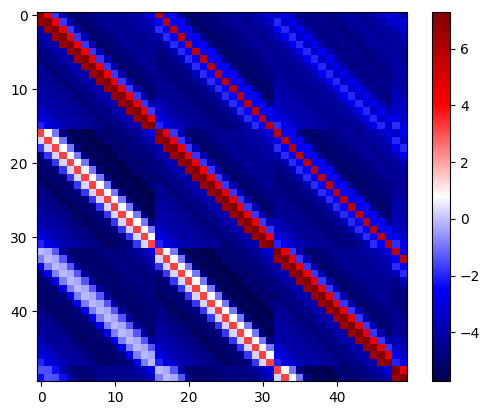

In [25]:
import torch

def stationary_to_full(rel_bias_table: torch.Tensor) -> torch.Tensor:
    """
    rel_bias_table: (2G-1, 2G-1) tensor of stationary biases
    returns: (G*G, G*G) full covariance matrix
    """
    # recover G
    D = rel_bias_table.shape[0]
    assert D % 2 == 1, "table must be odd-sized"
    G = (D + 1) // 2       # e.g. D=31 -> G=16
    N = G * G              # 256

    # compute patch grid coordinates 0..G-1
    idx = torch.arange(N)
    rows = idx // G        # shape (N,)
    cols = idx %  G        # shape (N,)

    # pairwise differences dr, dc in [-(G-1) .. (G-1)]
    dr = rows[:, None] - rows[None, :]   # (N, N)
    dc = cols[:, None] - cols[None, :]   # (N, N)

    # shift to [0 .. 2G-2] to index into rel_bias_table
    ir = dr + (G - 1)    # now in [0 .. 2G-2]
    ic = dc + (G - 1)

    # gather
    full = rel_bias_table[ir, ic]  # (N, N)
    return full

# example:
rel31 = model.rel_bias_table.cpu().detach().numpy()    # your learned table
full256 = stationary_to_full(rel31)
plt.imshow(full256[:50,:50],cmap="seismic")  # torch.Size([256, 256])
plt.colorbar()
plt.show()

# Sample

In [ ]:
# Assume training_data is already defined with shape (N, H, W)
N, H, W = training_data.shape

# Set parameters.
vocab, counts, mask_token = build_vocabulary(training_data, patch_size, cap_size=vocab_cap)
patch_dim = patch_size ** 2
num_patches = (H // patch_size) ** 2


# Create the model and load weights.
PATH = "Models/4x4_model_epoch_900_smooth_data.pth"
model = StackedContextViT(vocab, mask_token, patch_dim, num_patches,
                           emb_dim, num_heads, num_layers, ffn_dim)
# Note: if your torch.load expects "weights_only", adjust accordingly.
model.load_state_dict(torch.load(PATH, map_location='cpu'))  # remove weights_only if not applicable
model.eval()

flattened_condition_indices = np.zeros(len(condition_indices_new))
for i in range(len(condition_indices_new)):
    flattened_condition_indices[i] = condition_indices_x[i] * 64 + condition_indices_y[i]
flattened_condition_indices = flattened_condition_indices.astype(int)

# Generate a test image and plot
cond_img,ll = generate_image(model,patch_size,image_size=H,condition_indices=flattened_condition_indices,condition_values=condition_values_new)

plt.imshow(cond_img.cpu().detach().numpy(),cmap='gray')
plt.scatter(condition_indices_y,condition_indices_x,c=condition_values_new,cmap='viridis')
plt.title(f"Log-likelihood of sample:{ll:.2f}")
plt.show()

RuntimeError: Error(s) in loading state_dict for StackedContextViT:
	Unexpected key(s) in state_dict: "mask_token". 

# Sample without Positional Encoding

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_wo_PE = copy.deepcopy(model)
model_wo_PE.pos_emb = nn.Parameter(
    torch.zeros(num_patches, emb_dim, device='cpu')
)
print("Positional Encoding:",model_wo_PE.pos_emb)
# Generate a test image and plot
cond_img,ll = generate_image(model_wo_PE,patch_size,image_size=H,condition_indices=flattened_condition_indices,condition_values=condition_values_new)
plt.imshow(cond_img.cpu().detach().numpy(),cmap='gray')
plt.scatter(condition_indices_y,condition_indices_x,c=condition_values_new,cmap='viridis')
plt.title(f"Log-likelihood of sample:{ll:.2f}")
plt.show()

# Sample without Positional Encoding and With Gauss Covariance matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Parameters
grid_size = 64
length_scale = 0.8
sigma_sq = 1.0

# Create 2D coordinates for a 16x16 grid
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
xx, yy = np.meshgrid(x, y)
coords = np.stack([xx.ravel(), yy.ravel()], axis=1)  # shape: (256, 2)

# Compute pairwise squared Euclidean distances
sqdist = cdist(coords, coords, 'sqeuclidean')

# Gaussian covariance matrix
cov_matrix = sigma_sq * np.exp(-0.5 * sqdist / length_scale**2)

# Sample from zero-mean multivariate normal distribution
mean = np.zeros(coords.shape[0])
sample = np.random.multivariate_normal(mean, cov_matrix)

# Reshape to 2D field for visualization
field = sample.reshape(grid_size, grid_size)
trunc_field = np.zeros_like(field)
trunc_field[field < 0] = 0
trunc_field[field > 1] = 1

# Plot the sampled GRF
plt.figure(figsize=(6, 5))
plt.imshow(trunc_field, cmap='coolwarm', origin='lower')
plt.colorbar(label='Field Value')
plt.title('Sample from Zero-Mean 2D Gaussian Random Field')
plt.tight_layout()
plt.show()

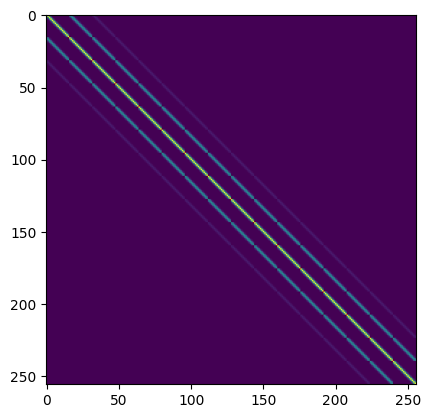

In [ ]:
import numpy as np

# assume cov_matrix is your 4096×4096 full‐field covariance
grid_size   = 64
patch_size  = 4
n_patches   = grid_size // patch_size      # 16
P           = n_patches**2                 # 256

# 1) build a 4096‐vector that maps each pixel → patch index 0…255
row_ids     = np.arange(grid_size) // patch_size           # length 64: [0,0,0,0,1,1,...,15]
col_ids     = np.arange(grid_size) // patch_size           # same for columns
# broadcast to 64×64 then flatten
patch_map   = (row_ids[:,None] * n_patches + col_ids[None,:]).ravel()

# 2) build a “membership” matrix M of shape (4096,256)
#    M[k,i] = 1 if pixel k ∈ patch i, else 0
M = np.zeros((grid_size**2, P))
for pix_idx, patch_idx in enumerate(patch_map):
    M[pix_idx, patch_idx] = 1

# 3) normalize to get patch‐means: divide each column by 16
M /= (patch_size**2)

# 4) compute the patch‐covariance
#    Cov[ i, j ] = Cov( mean of patch i, mean of patch j )
patch_cov = M.T @ cov_matrix @ M    # shape: (256, 256)

# now `patch_cov` is your desired 256×256 patch covariance matrix
plt.imshow(patch_cov)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_wo_APE_w_Gauss_RPE = copy.deepcopy(model)
model_wo_APE_w_Gauss_RPE.pos_emb = nn.Parameter(
    torch.zeros(num_patches, emb_dim, device='cpu')
)

model_wo_APE_w_Gauss_RPE.rel_bias = nn.Parameter(
    torch.tensor(cov_matrix, device='cpu')
)
print("Positional Encoding:",model_wo_PE.pos_emb)
# Generate a test image and plot
cond_img,ll = generate_image(model_wo_PE,patch_size,image_size=H,condition_indices=flattened_condition_indices,condition_values=condition_values_new)
plt.imshow(cond_img.cpu().detach().numpy(),cmap='gray')
plt.scatter(condition_indices_y,condition_indices_x,c=condition_values_new,cmap='viridis')
plt.title(f"Log-likelihood of sample:{ll:.2f}")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, ffn_dim,dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=emb_dim,
                                          num_heads=num_heads,
                                          dropout=dropout,
                                          batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(emb_dim, ffn_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ffn_dim, emb_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(emb_dim)

    def forward(self, x, attn_mask=None):
        # attn_mask here is [N,N] if provided
        out, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = self.norm1(x + self.drop1(out))
        x = self.norm2(x + self.ffn(x))
        return x

class StackedContextViT(nn.Module):
    def __init__(
        self,
        vocab,                # [V, patch_dim]
        mask_token,           # Parameter [patch_dim]
        patch_dim,
        num_patches,          # N
        emb_dim=128,
        num_heads=1,
        num_layers=1,
        ffn_dim=None,
        use_pos_emb: bool = True,
        pos_emb_init: torch.Tensor | None = None,
        use_rel_bias: bool = True,
        rel_bias_init: torch.Tensor | None = None,  # if provided must be [2G-1,2G-1]
    ):
        super().__init__()
        self.vocab      = vocab
        self.mask_token = mask_token
        self.vocab_size = vocab.size(0)
        self.patch_proj = nn.Linear(patch_dim, emb_dim)
        self.out_drop = nn.Dropout(0.1)

        # absolute positional embedding
        self.use_pos_emb = use_pos_emb
        if use_pos_emb:
            pe = pos_emb_init if (pos_emb_init is not None) \
                 else torch.zeros(num_patches, emb_dim)
            self.pos_emb = nn.Parameter(pe)
        else:
            # dummy so attribute exists, but never used
            self.register_buffer('pos_emb', torch.zeros(1))

        # stationary relative‐bias table
        self.use_rel_bias = use_rel_bias
        G = int(math.sqrt(num_patches))
        if use_rel_bias:
            # table of size (2G-1)×(2G-1)
            if rel_bias_init is not None:
                assert rel_bias_init.shape == (2*G-1, 2*G-1)
                rb = rel_bias_init
            else:
                rb = torch.zeros(2*G-1, 2*G-1)
            self.rel_bias_table = nn.Parameter(rb)
            self.G = G
        else:
            self.register_buffer('rel_bias_table', torch.zeros(1))
            self.G = None

        # transformer layers
        ffn_dim = ffn_dim or (emb_dim * 4)
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(emb_dim, num_heads, ffn_dim)
            for _ in range(num_layers)
        ])

        self.out_proj = nn.Linear(emb_dim, self.vocab_size)

    def forward(self, patches, mask_rate):
        """
        patches: [B, N, patch_dim]
        """
        B, N, _ = patches.shape
        G = self.G  # sqrt(N) if rel_bias

        # 1) mask
        mask = torch.rand(B, N, device=patches.device) < mask_rate
        x = patches.clone()
        x[mask] = self.mask_token.to(x.device)

        # 2) patch → embedding
        x = self.patch_proj(x)

        # 3) add absolute pos‐emb if desired
        if self.use_pos_emb:
            x = x + self.pos_emb.unsqueeze(0)

        # 4) build the [N×N] attention mask from stationary table
        attn_bias = None
        if self.use_rel_bias:
            # compute row/col indices for each patch 0..N-1
            idx = torch.arange(N, device=x.device)
            rows = idx // G   # shape [N]
            cols = idx %  G   # shape [N]

            # pairwise offsets
            dr = rows[:,None] - rows[None,:]   # [N,N] in range [-(G-1),(G-1)]
            dc = cols[:,None] - cols[None,:]

            # shift to [0..2G-2]
            ir = dr + (G-1)
            ic = dc + (G-1)

            attn_bias = self.rel_bias_table[ir, ic]  # [N,N]

        # 5) apply transformer layers
        for layer in self.layers:
            x = layer(x, attn_mask=attn_bias)

        # 6) final logits
        logits = self.out_drop(self.out_proj(x))  # [B, N, V]
        return logits, mask

In [ ]:
from ViT_sampling import *
#from ViT_sampling_MLA import *
########################################
# Training Loop with Progress Bar and Updated Plotting
########################################

import wandb  # make sure wandb is installed: pip install wandb
def run_training(training_data, nr_epochs, batch_size, mask_rate,
                 final_mask_rate, mask_schedule, patch_size, num_heads,
                 num_layers, ffn_dim, learning_rate, emb_dim, vocab_cap,
                 use_pos_emb=True,pos_emb=None,use_rel_bias=True,rel_bias=None):
    """
    training_data: numpy array or tensor of shape [N, H, W] (binary images)
    nr_epochs: number of epochs for training
    batch_size: training batch size
    mask_rate: initial masking probability.
    final_mask_rate: final masking probability.
    mask_schedule: one of 'linear', 'exp', or 'log' that defines the growth of mask_rate.
    patch_size: patch size (square); for your experiment use 2 if desired.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Initialize wandb
    wandb.init(project="ViT_conditional", config={
        "nr_epochs": nr_epochs,
        "batch_size": batch_size,
        "mask_rate": mask_rate,
        "final_mask_rate": final_mask_rate,
        "mask_schedule": mask_schedule,
        "patch_size": patch_size,
        "num_heads": num_heads,
        "num_layers": num_layers,
        "ffn_dim": ffn_dim,
        "learning_rate": learning_rate,
        "emb_dim": emb_dim
    })

    if not isinstance(training_data, torch.Tensor):
        training_data = torch.tensor(training_data, dtype=torch.float32)

    dataset = BinaryImageDataset(training_data)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    B_total, H_img, W_img = training_data.shape
    num_patches = (H_img // patch_size) * (W_img // patch_size)
    patch_dim = patch_size * patch_size

    # Build vocabulary and mask token.
    vocab, counts, mask_token = build_vocabulary(training_data, patch_size, cap_size=vocab_cap)
    print("vocab size:\n", vocab.size(0))

    # Create the ViT model.
    model = StackedContextViT(
    vocab=vocab.to(device),
    mask_token=mask_token.to(device),
    patch_dim=patch_dim,
    num_patches=num_patches,
    emb_dim=emb_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    ffn_dim=ffn_dim,
    use_pos_emb=use_pos_emb,
    pos_emb_init=pos_emb,     # either None or your [N×emb_dim] tensor
    use_rel_bias=use_rel_bias,
    rel_bias_init=rel_bias    # either None or your [N×N] tensor
    )
    model.to(device)
    model.vocab = model.vocab.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    #Weight for reconstruction loss
    alpha = 0.01

    for epoch in range(nr_epochs):
        # Compute the current masking rate according to the selected schedule.
        if mask_schedule == "linear":
            current_mask_rate = mask_rate + (final_mask_rate - mask_rate) * (epoch / (nr_epochs - 1))
        elif mask_schedule == "exp":
            current_mask_rate = mask_rate * ((final_mask_rate / mask_rate) ** (epoch / (nr_epochs - 1)))
        elif mask_schedule == "log":
            current_mask_rate = mask_rate + (final_mask_rate - mask_rate) * (math.log(epoch + 1) / math.log(nr_epochs))
        else:
            current_mask_rate = mask_rate  # fallback to constant rate

        model.train()
        total_loss = 0.0
        total_correct = 0
        total_masked = 0

        # Variables to store outputs from the last batch for plotting.
        last_batch_images = None
        last_batch_patches = None
        last_batch_mask = None
        last_batch_logits = None
        last_targets = None

        # Progress bar for this epoch.
        for batch in tqdm(loader, desc=f"Epoch {epoch+1}/{nr_epochs}"):
            batch = batch.to(device)
            patches = BinaryImageDataset.batch_to_patches(batch, patch_size)  # shape [B, N, patch_dim]
            B, N, P = patches.shape

            logits, mask = model(patches, current_mask_rate)

            patches_bin = patches.round()
            patches_flat = patches_bin.view(B * N, P)
            dists = torch.cdist(patches_flat, model.vocab)
            targets = torch.argmin(dists, dim=1).view(B, N)

            if mask.sum() > 0:
                loss_mask = criterion(logits[mask], targets[mask])
            else:
                loss_mask = torch.tensor(0.0, device=device)

            pred_ids     = logits.argmax(dim=-1)             # [B, N]
            pred_patches = model.vocab[pred_ids]             # [B, N, D]
            # vectorized reassembly:
            recon_images = []
            for i in range(B):
                recon_images.append(
                    patches_to_image(pred_patches[i], (H_img, W_img), patch_size)
                )
            recon_images = torch.stack(recon_images).to(device)  # [B, H, W]
            loss_recon = F.l1_loss(recon_images, batch)

            # combined loss
            loss = loss_mask + alpha * loss_recon

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss_mask.item() * mask.sum().item()
            preds = logits.argmax(dim=-1)
            total_correct += (preds[mask] == targets[mask]).sum().item()
            total_masked += mask.sum().item()

            # Save last batch data (including targets) for plotting.
            last_batch_images = batch.detach().cpu()
            last_batch_patches = patches.detach().cpu()
            last_batch_mask = mask.detach().cpu()
            last_batch_logits = logits.detach().cpu()
            last_targets = targets.detach().cpu()

        avg_loss = total_loss / max(1, total_masked)
        acc = total_correct / max(1, total_masked)
        scheduler.step() #Change laber
        # Log epoch metrics.
        wandb.log({
            "epoch": epoch+1,
            "masked_CE": loss_mask.item(),
            "recon_L1": loss_recon.item(),
            "combined_loss": loss.item(),
            "avg_loss": avg_loss,
            "masked_accuracy": acc,
            "mask_rate": current_mask_rate,
            "learning_rate": scheduler.get_last_lr()[0]
        })
        print(f"Epoch {epoch+1}/{nr_epochs} | Loss: {avg_loss:.4f} | Masked Acc: {acc:.4f}")

        if (epoch + 1) % 100 == 0:
          torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
          print(f"Saved model at epoch {epoch+1}")

        # ---- Every 10 epochs, perform conditional generation and log to wandb ----
        if (epoch+1) % 50 == 0:
            # Sample conditions for generation.
            condition_indices = np.array([1726,3797,4211,4543,3953,3347,1897,2015,4424,1942,2108,4350,1019,4068,2911])
            condition_values = np.array([0,1,0,1,1,1,0,1,0,1,0,1,1,1,0])
            condition_indices_x = (condition_indices // 80) - 8
            condition_indices_y = (condition_indices % 80) - 8
            flattened_condition_indices = np.zeros(len(condition_indices))
            for i in range(len(condition_indices)):
                flattened_condition_indices[i] = condition_indices_x[i] * 64 + condition_indices_y[i]
            flattened_condition_indices = flattened_condition_indices.astype(int)
            generated_img, log_likelihood_sum = generate_image(model, patch_size, W_img, condition_indices=flattened_condition_indices, condition_values=condition_values)
            # Create a figure for the generated image.
            fig_gen, ax_gen = plt.subplots(figsize=(12,12))
            # Convert conditions to grid coordinates for plotting.
            ax_gen.imshow(generated_img.cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
            ax_gen.scatter(condition_indices_y, condition_indices_x, c=condition_values, cmap='viridis')
            ax_gen.set_title(f"Conditional Generation @ Epoch {epoch+1}\nLL: {log_likelihood_sum:.4f}")
            ax_gen.axis("off")
            wandb.log({"conditional_generation": wandb.Image(fig_gen, caption=f"Epoch {epoch+1}")})
            plt.close(fig_gen)

        # ---- (Optional) Plotting the last batch reconstruction and log to wandb ----
        if (epoch+1) % 10 == 0:
          if last_batch_images is not None:
              last_image = last_batch_images[-1]         # [H_img, W_img]
              last_orig_patches = last_batch_patches[-1]    # [N, patch_dim]
              last_mask = last_batch_mask[-1]               # [N]
              last_logits = last_batch_logits[-1]           # [N, vocab_size]
              last_targets_img = last_targets[-1]           # [N]

              last_pred = last_logits.argmax(dim=-1)

              reconstructed_patches = last_orig_patches.clone()
              pred_patches = model.vocab[last_pred].detach().cpu()
              reconstructed_patches[last_mask] = pred_patches[last_mask]

              orig_img = last_image.numpy()
              recon_img = patches_to_image(reconstructed_patches, (H_img, W_img), patch_size).numpy()

              fig_recon, axes_recon = plt.subplots(1, 2, figsize=(24, 12))
              axes_recon[0].imshow(orig_img, cmap='gray', vmin=0, vmax=1)
              axes_recon[0].set_title("Original Image")
              axes_recon[0].axis("off")

              axes_recon[1].imshow(recon_img, cmap='gray', vmin=0, vmax=1)
              axes_recon[1].set_title("Reconstructed Image")
              axes_recon[1].axis("off")

              num_patches_h = H_img // patch_size
              num_patches_w = W_img // patch_size
              N_patches = last_orig_patches.shape[0]
              for i in range(N_patches):
                  if last_mask[i]:
                      row = i // num_patches_w
                      col = i % num_patches_w
                      if last_pred[i] == last_targets_img[i]:
                          border_color = "green"
                      else:
                          border_color = "red"
                      rect = mpatches.Rectangle((col * patch_size -.5, row * patch_size -.5),
                                                patch_size, patch_size,
                                                linewidth=2, edgecolor=border_color, facecolor='none')
                      axes_recon[1].add_patch(rect)

              plt.suptitle(f"Epoch {epoch+1}")
              wandb.log({"reconstruction": wandb.Image(fig_recon, caption=f"Epoch {epoch+1}")})
              plt.close(fig_recon)

    return model, avg_loss

In [ ]:
# Try training for, say, 500 epochs; you can also try mask_rate=1.0 for a stricter overfit test.
nr_epochs = 1000
batch_size = 100
mask_rate = 0.05  # Try also mask_rate = 1.0 to check if the network can memorize given only positional cues.
final_mask_rate = 0.95
mask_schedule = "linear"
patch_size = 4
num_heads = 2
num_layers = 2
ffn_dim = 256
emb_dim = 64
learning_rate = 1e-3
vocab_cap = 100000
use_pos_emb = False
rel_bias_init = torch.tensor(patch_cov,dtype=torch.float32)
trained_model = run_training(training_data, nr_epochs, batch_size, mask_rate, final_mask_rate, mask_schedule, patch_size,
                             num_heads, num_layers, ffn_dim, learning_rate, emb_dim, vocab_cap,use_pos_emb=use_pos_emb,rel_bias=rel_bias_init)


avg_loss,█▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
combined_loss,█▇▆▅▄▄▃▃▅▄▃▃▃▄▄▃▄▃▃▃▃▂▂▂▃▂▂▂▂▃▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,█████████████████████████████████████▁▁▁
mask_rate,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
masked_CE,█▇▆▅▄▃▃▄▅▄▃▃▄▃▄▄▃▄▃▃▂▂▂▃▃▂▂▂▃▂▂▁▂▁▂▁▁▁▁▁
masked_accuracy,▁▂▄▇▇███████████████████████████████████
recon_L1,▂▆▅█▇▇▇▇▇▆▇▇▇▆▆▆▆▅▅▆▅▅▄▄▄▃▂▃▂▃▁▂▂▃▂▃▂▂▁▂
avg_loss,3.39417
combined_loss,3.46512
epoch,54


vocab size:
 5485


Epoch 1/1000: 100%|██████████| 90/90 [00:38<00:00,  2.34it/s]


Epoch 1/1000 | Loss: 5.7154 | Masked Acc: 0.2177


Epoch 2/1000: 100%|██████████| 90/90 [00:38<00:00,  2.33it/s]


Epoch 2/1000 | Loss: 4.9439 | Masked Acc: 0.2658


Epoch 3/1000: 100%|██████████| 90/90 [00:38<00:00,  2.34it/s]


Epoch 3/1000 | Loss: 4.9316 | Masked Acc: 0.2821


Epoch 4/1000: 100%|██████████| 90/90 [00:38<00:00,  2.33it/s]


Epoch 4/1000 | Loss: 4.9455 | Masked Acc: 0.2701


Epoch 5/1000: 100%|██████████| 90/90 [00:38<00:00,  2.33it/s]


Epoch 5/1000 | Loss: 4.9381 | Masked Acc: 0.2779


Epoch 6/1000: 100%|██████████| 90/90 [00:38<00:00,  2.33it/s]


Epoch 6/1000 | Loss: 4.8054 | Masked Acc: 0.3642


Epoch 7/1000: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


Epoch 7/1000 | Loss: 4.6710 | Masked Acc: 0.3991


Epoch 8/1000: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 8/1000 | Loss: 4.6042 | Masked Acc: 0.4085


Epoch 9/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 9/1000 | Loss: 4.6062 | Masked Acc: 0.4070


Epoch 10/1000: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 10/1000 | Loss: 4.5644 | Masked Acc: 0.4149


Epoch 11/1000: 100%|██████████| 90/90 [00:39<00:00,  2.31it/s]


Epoch 11/1000 | Loss: 4.5531 | Masked Acc: 0.4151


Epoch 12/1000: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 12/1000 | Loss: 4.5403 | Masked Acc: 0.4162


Epoch 13/1000: 100%|██████████| 90/90 [00:39<00:00,  2.31it/s]


Epoch 13/1000 | Loss: 4.5065 | Masked Acc: 0.4209


Epoch 14/1000: 100%|██████████| 90/90 [00:39<00:00,  2.31it/s]


Epoch 14/1000 | Loss: 4.5099 | Masked Acc: 0.4190


Epoch 15/1000: 100%|██████████| 90/90 [00:39<00:00,  2.31it/s]


Epoch 15/1000 | Loss: 4.4963 | Masked Acc: 0.4209


Epoch 16/1000: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 16/1000 | Loss: 4.5017 | Masked Acc: 0.4191


Epoch 17/1000: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 17/1000 | Loss: 4.4918 | Masked Acc: 0.4201


Epoch 18/1000: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 18/1000 | Loss: 4.4945 | Masked Acc: 0.4179


Epoch 19/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 19/1000 | Loss: 4.4867 | Masked Acc: 0.4206


Epoch 20/1000: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 20/1000 | Loss: 4.4856 | Masked Acc: 0.4196


Epoch 21/1000: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


Epoch 21/1000 | Loss: 4.4841 | Masked Acc: 0.4193


Epoch 22/1000: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 22/1000 | Loss: 4.4907 | Masked Acc: 0.4177


Epoch 23/1000: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 23/1000 | Loss: 4.4701 | Masked Acc: 0.4209


Epoch 24/1000: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 24/1000 | Loss: 4.4798 | Masked Acc: 0.4187


Epoch 25/1000: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 25/1000 | Loss: 4.4767 | Masked Acc: 0.4196


Epoch 26/1000: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 26/1000 | Loss: 4.4780 | Masked Acc: 0.4188


Epoch 27/1000: 100%|██████████| 90/90 [00:39<00:00,  2.31it/s]


Epoch 27/1000 | Loss: 4.4651 | Masked Acc: 0.4212


Epoch 28/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 28/1000 | Loss: 4.4713 | Masked Acc: 0.4190


Epoch 29/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 29/1000 | Loss: 4.4723 | Masked Acc: 0.4183


Epoch 30/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 30/1000 | Loss: 4.4650 | Masked Acc: 0.4196


Epoch 31/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 31/1000 | Loss: 4.4729 | Masked Acc: 0.4180


Epoch 32/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 32/1000 | Loss: 4.4614 | Masked Acc: 0.4214


Epoch 33/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 33/1000 | Loss: 4.4668 | Masked Acc: 0.4187


Epoch 34/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 34/1000 | Loss: 4.4666 | Masked Acc: 0.4194


Epoch 35/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 35/1000 | Loss: 4.4571 | Masked Acc: 0.4204


Epoch 36/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 36/1000 | Loss: 4.4585 | Masked Acc: 0.4197


Epoch 37/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 37/1000 | Loss: 4.4556 | Masked Acc: 0.4198


Epoch 38/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 38/1000 | Loss: 4.4498 | Masked Acc: 0.4217


Epoch 39/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 39/1000 | Loss: 4.4537 | Masked Acc: 0.4198


Epoch 40/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 40/1000 | Loss: 4.4513 | Masked Acc: 0.4198


Epoch 41/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 41/1000 | Loss: 4.4024 | Masked Acc: 0.4194


Epoch 42/1000: 100%|██████████| 90/90 [00:39<00:00,  2.31it/s]


Epoch 42/1000 | Loss: 4.3658 | Masked Acc: 0.4184


Epoch 43/1000: 100%|██████████| 90/90 [00:39<00:00,  2.31it/s]


Epoch 43/1000 | Loss: 4.3532 | Masked Acc: 0.4198


Epoch 44/1000: 100%|██████████| 90/90 [00:39<00:00,  2.31it/s]


Epoch 44/1000 | Loss: 4.3518 | Masked Acc: 0.4194


Epoch 45/1000: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 45/1000 | Loss: 4.3406 | Masked Acc: 0.4192


Epoch 46/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 46/1000 | Loss: 4.3365 | Masked Acc: 0.4182


Epoch 47/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 47/1000 | Loss: 4.3415 | Masked Acc: 0.4172


Epoch 48/1000: 100%|██████████| 90/90 [00:39<00:00,  2.31it/s]


Epoch 48/1000 | Loss: 4.3262 | Masked Acc: 0.4175


Epoch 49/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 49/1000 | Loss: 4.3017 | Masked Acc: 0.4164


Epoch 50/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 50/1000 | Loss: 4.2866 | Masked Acc: 0.4157


Epoch 51/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 51/1000 | Loss: 4.2618 | Masked Acc: 0.4166


Epoch 52/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 52/1000 | Loss: 4.2434 | Masked Acc: 0.4194


Epoch 53/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 53/1000 | Loss: 4.2325 | Masked Acc: 0.4188


Epoch 54/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 54/1000 | Loss: 4.2341 | Masked Acc: 0.4168


Epoch 55/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 55/1000 | Loss: 4.2340 | Masked Acc: 0.4159


Epoch 56/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 56/1000 | Loss: 4.2214 | Masked Acc: 0.4156


Epoch 57/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 57/1000 | Loss: 4.2162 | Masked Acc: 0.4165


Epoch 58/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 58/1000 | Loss: 4.1953 | Masked Acc: 0.4189


Epoch 59/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 59/1000 | Loss: 4.1806 | Masked Acc: 0.4194


Epoch 60/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 60/1000 | Loss: 4.1789 | Masked Acc: 0.4197


Epoch 61/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 61/1000 | Loss: 4.1708 | Masked Acc: 0.4191


Epoch 62/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 62/1000 | Loss: 4.1646 | Masked Acc: 0.4200


Epoch 63/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 63/1000 | Loss: 4.1551 | Masked Acc: 0.4195


Epoch 64/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 64/1000 | Loss: 4.1385 | Masked Acc: 0.4210


Epoch 65/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 65/1000 | Loss: 4.1278 | Masked Acc: 0.4211


Epoch 66/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 66/1000 | Loss: 4.1271 | Masked Acc: 0.4214


Epoch 67/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 67/1000 | Loss: 4.1156 | Masked Acc: 0.4207


Epoch 68/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 68/1000 | Loss: 4.1075 | Masked Acc: 0.4212


Epoch 69/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 69/1000 | Loss: 4.0984 | Masked Acc: 0.4223


Epoch 70/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 70/1000 | Loss: 4.0842 | Masked Acc: 0.4229


Epoch 71/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 71/1000 | Loss: 4.0751 | Masked Acc: 0.4240


Epoch 72/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 72/1000 | Loss: 4.0652 | Masked Acc: 0.4239


Epoch 73/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 73/1000 | Loss: 4.0512 | Masked Acc: 0.4252


Epoch 74/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 74/1000 | Loss: 4.0485 | Masked Acc: 0.4252


Epoch 75/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 75/1000 | Loss: 4.0434 | Masked Acc: 0.4255


Epoch 76/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 76/1000 | Loss: 4.0364 | Masked Acc: 0.4252


Epoch 77/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 77/1000 | Loss: 4.0299 | Masked Acc: 0.4254


Epoch 78/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 78/1000 | Loss: 4.0262 | Masked Acc: 0.4253


Epoch 79/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 79/1000 | Loss: 4.0271 | Masked Acc: 0.4256


Epoch 80/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 80/1000 | Loss: 4.0169 | Masked Acc: 0.4269


Epoch 81/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 81/1000 | Loss: 3.9987 | Masked Acc: 0.4280


Epoch 82/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 82/1000 | Loss: 4.0028 | Masked Acc: 0.4276


Epoch 83/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 83/1000 | Loss: 4.0000 | Masked Acc: 0.4290


Epoch 84/1000: 100%|██████████| 90/90 [00:39<00:00,  2.31it/s]


Epoch 84/1000 | Loss: 3.9873 | Masked Acc: 0.4299


Epoch 85/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 85/1000 | Loss: 3.9802 | Masked Acc: 0.4313


Epoch 86/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 86/1000 | Loss: 3.9858 | Masked Acc: 0.4297


Epoch 87/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 87/1000 | Loss: 3.9735 | Masked Acc: 0.4312


Epoch 88/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 88/1000 | Loss: 3.9747 | Masked Acc: 0.4308


Epoch 89/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 89/1000 | Loss: 3.9705 | Masked Acc: 0.4325


Epoch 90/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 90/1000 | Loss: 3.9759 | Masked Acc: 0.4309


Epoch 91/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 91/1000 | Loss: 3.9587 | Masked Acc: 0.4338


Epoch 92/1000: 100%|██████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 92/1000 | Loss: 3.9612 | Masked Acc: 0.4338


Epoch 93/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 93/1000 | Loss: 3.9624 | Masked Acc: 0.4331


Epoch 94/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 94/1000 | Loss: 3.9575 | Masked Acc: 0.4336


Epoch 95/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 95/1000 | Loss: 3.9490 | Masked Acc: 0.4358


Epoch 96/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 96/1000 | Loss: 3.9513 | Masked Acc: 0.4357


Epoch 97/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 97/1000 | Loss: 3.9458 | Masked Acc: 0.4362


Epoch 98/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 98/1000 | Loss: 3.9486 | Masked Acc: 0.4353


Epoch 99/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 99/1000 | Loss: 3.9510 | Masked Acc: 0.4341


Epoch 100/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 100/1000 | Loss: 3.9460 | Masked Acc: 0.4357
Saved model at epoch 100


Epoch 101/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 101/1000 | Loss: 3.9379 | Masked Acc: 0.4364


Epoch 102/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 102/1000 | Loss: 3.9328 | Masked Acc: 0.4366


Epoch 103/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 103/1000 | Loss: 3.9373 | Masked Acc: 0.4365


Epoch 104/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 104/1000 | Loss: 3.9285 | Masked Acc: 0.4368


Epoch 105/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 105/1000 | Loss: 3.9367 | Masked Acc: 0.4355


Epoch 106/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 106/1000 | Loss: 3.9256 | Masked Acc: 0.4381


Epoch 107/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 107/1000 | Loss: 3.9251 | Masked Acc: 0.4380


Epoch 108/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 108/1000 | Loss: 3.9266 | Masked Acc: 0.4375


Epoch 109/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 109/1000 | Loss: 3.9216 | Masked Acc: 0.4380


Epoch 110/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 110/1000 | Loss: 3.9257 | Masked Acc: 0.4371


Epoch 111/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 111/1000 | Loss: 3.9192 | Masked Acc: 0.4392


Epoch 112/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 112/1000 | Loss: 3.9130 | Masked Acc: 0.4381


Epoch 113/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 113/1000 | Loss: 3.9096 | Masked Acc: 0.4385


Epoch 114/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 114/1000 | Loss: 3.9063 | Masked Acc: 0.4385


Epoch 115/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 115/1000 | Loss: 3.9101 | Masked Acc: 0.4381


Epoch 116/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 116/1000 | Loss: 3.9054 | Masked Acc: 0.4386


Epoch 117/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 117/1000 | Loss: 3.9097 | Masked Acc: 0.4383


Epoch 118/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 118/1000 | Loss: 3.9036 | Masked Acc: 0.4391


Epoch 119/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 119/1000 | Loss: 3.8969 | Masked Acc: 0.4401


Epoch 120/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 120/1000 | Loss: 3.9016 | Masked Acc: 0.4389


Epoch 121/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 121/1000 | Loss: 3.8949 | Masked Acc: 0.4391


Epoch 122/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 122/1000 | Loss: 3.8988 | Masked Acc: 0.4384


Epoch 123/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 123/1000 | Loss: 3.8898 | Masked Acc: 0.4399


Epoch 124/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 124/1000 | Loss: 3.8955 | Masked Acc: 0.4389


Epoch 125/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 125/1000 | Loss: 3.8886 | Masked Acc: 0.4401


Epoch 126/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 126/1000 | Loss: 3.8873 | Masked Acc: 0.4395


Epoch 127/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 127/1000 | Loss: 3.8872 | Masked Acc: 0.4403


Epoch 128/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 128/1000 | Loss: 3.8928 | Masked Acc: 0.4387


Epoch 129/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 129/1000 | Loss: 3.8850 | Masked Acc: 0.4411


Epoch 130/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 130/1000 | Loss: 3.8849 | Masked Acc: 0.4405


Epoch 131/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 131/1000 | Loss: 3.8794 | Masked Acc: 0.4404


Epoch 132/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 132/1000 | Loss: 3.8805 | Masked Acc: 0.4404


Epoch 133/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 133/1000 | Loss: 3.8728 | Masked Acc: 0.4415


Epoch 134/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 134/1000 | Loss: 3.8800 | Masked Acc: 0.4408


Epoch 135/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 135/1000 | Loss: 3.8765 | Masked Acc: 0.4410


Epoch 136/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 136/1000 | Loss: 3.8716 | Masked Acc: 0.4415


Epoch 137/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 137/1000 | Loss: 3.8671 | Masked Acc: 0.4416


Epoch 138/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 138/1000 | Loss: 3.8658 | Masked Acc: 0.4418


Epoch 139/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 139/1000 | Loss: 3.8596 | Masked Acc: 0.4429


Epoch 140/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 140/1000 | Loss: 3.8691 | Masked Acc: 0.4414


Epoch 141/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 141/1000 | Loss: 3.8660 | Masked Acc: 0.4418


Epoch 142/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 142/1000 | Loss: 3.8653 | Masked Acc: 0.4414


Epoch 143/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 143/1000 | Loss: 3.8637 | Masked Acc: 0.4409


Epoch 144/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 144/1000 | Loss: 3.8651 | Masked Acc: 0.4419


Epoch 145/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 145/1000 | Loss: 3.8663 | Masked Acc: 0.4416


Epoch 146/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 146/1000 | Loss: 3.8589 | Masked Acc: 0.4417


Epoch 147/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 147/1000 | Loss: 3.8588 | Masked Acc: 0.4422


Epoch 148/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 148/1000 | Loss: 3.8596 | Masked Acc: 0.4417


Epoch 149/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 149/1000 | Loss: 3.8576 | Masked Acc: 0.4416


Epoch 150/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 150/1000 | Loss: 3.8566 | Masked Acc: 0.4415


Epoch 151/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 151/1000 | Loss: 3.8561 | Masked Acc: 0.4414


Epoch 152/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 152/1000 | Loss: 3.8529 | Masked Acc: 0.4419


Epoch 153/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 153/1000 | Loss: 3.8551 | Masked Acc: 0.4420


Epoch 154/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 154/1000 | Loss: 3.8489 | Masked Acc: 0.4426


Epoch 155/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 155/1000 | Loss: 3.8553 | Masked Acc: 0.4422


Epoch 156/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 156/1000 | Loss: 3.8554 | Masked Acc: 0.4414


Epoch 157/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 157/1000 | Loss: 3.8557 | Masked Acc: 0.4413


Epoch 158/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 158/1000 | Loss: 3.8547 | Masked Acc: 0.4417


Epoch 159/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 159/1000 | Loss: 3.8603 | Masked Acc: 0.4406


Epoch 160/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 160/1000 | Loss: 3.8483 | Masked Acc: 0.4430


Epoch 161/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 161/1000 | Loss: 3.8475 | Masked Acc: 0.4420


Epoch 162/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 162/1000 | Loss: 3.8577 | Masked Acc: 0.4401


Epoch 163/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 163/1000 | Loss: 3.8565 | Masked Acc: 0.4413


Epoch 164/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 164/1000 | Loss: 3.8522 | Masked Acc: 0.4413


Epoch 165/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 165/1000 | Loss: 3.8493 | Masked Acc: 0.4422


Epoch 166/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 166/1000 | Loss: 3.8514 | Masked Acc: 0.4411


Epoch 167/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 167/1000 | Loss: 3.8412 | Masked Acc: 0.4438


Epoch 168/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 168/1000 | Loss: 3.8480 | Masked Acc: 0.4430


Epoch 169/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 169/1000 | Loss: 3.8505 | Masked Acc: 0.4416


Epoch 170/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 170/1000 | Loss: 3.8563 | Masked Acc: 0.4407


Epoch 171/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 171/1000 | Loss: 3.8523 | Masked Acc: 0.4409


Epoch 172/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 172/1000 | Loss: 3.8542 | Masked Acc: 0.4408


Epoch 173/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 173/1000 | Loss: 3.8509 | Masked Acc: 0.4416


Epoch 174/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 174/1000 | Loss: 3.8518 | Masked Acc: 0.4411


Epoch 175/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 175/1000 | Loss: 3.8507 | Masked Acc: 0.4411


Epoch 176/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 176/1000 | Loss: 3.8544 | Masked Acc: 0.4410


Epoch 177/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 177/1000 | Loss: 3.8500 | Masked Acc: 0.4423


Epoch 178/1000: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 178/1000 | Loss: 3.8530 | Masked Acc: 0.4409


Epoch 179/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 179/1000 | Loss: 3.8576 | Masked Acc: 0.4398


Epoch 180/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 180/1000 | Loss: 3.8490 | Masked Acc: 0.4423


Epoch 181/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 181/1000 | Loss: 3.8547 | Masked Acc: 0.4403


Epoch 182/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 182/1000 | Loss: 3.8515 | Masked Acc: 0.4412


Epoch 183/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 183/1000 | Loss: 3.8472 | Masked Acc: 0.4422


Epoch 184/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 184/1000 | Loss: 3.8483 | Masked Acc: 0.4413


Epoch 185/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 185/1000 | Loss: 3.8500 | Masked Acc: 0.4415


Epoch 186/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 186/1000 | Loss: 3.8496 | Masked Acc: 0.4422


Epoch 187/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 187/1000 | Loss: 3.8495 | Masked Acc: 0.4416


Epoch 188/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 188/1000 | Loss: 3.8485 | Masked Acc: 0.4416


Epoch 189/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 189/1000 | Loss: 3.8520 | Masked Acc: 0.4409


Epoch 190/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 190/1000 | Loss: 3.8475 | Masked Acc: 0.4416


Epoch 191/1000: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 191/1000 | Loss: 3.8555 | Masked Acc: 0.4409


Epoch 192/1000: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 192/1000 | Loss: 3.8478 | Masked Acc: 0.4417


Epoch 193/1000: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 193/1000 | Loss: 3.8485 | Masked Acc: 0.4415


Epoch 194/1000: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 194/1000 | Loss: 3.8524 | Masked Acc: 0.4413


Epoch 195/1000: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 195/1000 | Loss: 3.8532 | Masked Acc: 0.4405


Epoch 196/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 196/1000 | Loss: 3.8497 | Masked Acc: 0.4420


Epoch 197/1000: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 197/1000 | Loss: 3.8526 | Masked Acc: 0.4412


Epoch 198/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 198/1000 | Loss: 3.8544 | Masked Acc: 0.4411


Epoch 199/1000: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 199/1000 | Loss: 3.8558 | Masked Acc: 0.4410


Epoch 200/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 200/1000 | Loss: 3.8529 | Masked Acc: 0.4413
Saved model at epoch 200


Epoch 201/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 201/1000 | Loss: 3.8489 | Masked Acc: 0.4413


Epoch 202/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 202/1000 | Loss: 3.8480 | Masked Acc: 0.4419


Epoch 203/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 203/1000 | Loss: 3.8470 | Masked Acc: 0.4420


Epoch 204/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 204/1000 | Loss: 3.8526 | Masked Acc: 0.4416


Epoch 205/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 205/1000 | Loss: 3.8509 | Masked Acc: 0.4407


Epoch 206/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 206/1000 | Loss: 3.8470 | Masked Acc: 0.4421


Epoch 207/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 207/1000 | Loss: 3.8521 | Masked Acc: 0.4415


Epoch 208/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 208/1000 | Loss: 3.8518 | Masked Acc: 0.4411


Epoch 209/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 209/1000 | Loss: 3.8420 | Masked Acc: 0.4423


Epoch 210/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 210/1000 | Loss: 3.8554 | Masked Acc: 0.4405


Epoch 211/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 211/1000 | Loss: 3.8507 | Masked Acc: 0.4410


Epoch 212/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 212/1000 | Loss: 3.8538 | Masked Acc: 0.4400


Epoch 213/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 213/1000 | Loss: 3.8552 | Masked Acc: 0.4404


Epoch 214/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 214/1000 | Loss: 3.8531 | Masked Acc: 0.4411


Epoch 215/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 215/1000 | Loss: 3.8569 | Masked Acc: 0.4406


Epoch 216/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 216/1000 | Loss: 3.8549 | Masked Acc: 0.4409


Epoch 217/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 217/1000 | Loss: 3.8576 | Masked Acc: 0.4399


Epoch 218/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 218/1000 | Loss: 3.8541 | Masked Acc: 0.4411


Epoch 219/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 219/1000 | Loss: 3.8566 | Masked Acc: 0.4405


Epoch 220/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 220/1000 | Loss: 3.8586 | Masked Acc: 0.4396


Epoch 221/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 221/1000 | Loss: 3.8564 | Masked Acc: 0.4406


Epoch 222/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 222/1000 | Loss: 3.8587 | Masked Acc: 0.4403


Epoch 223/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 223/1000 | Loss: 3.8587 | Masked Acc: 0.4398


Epoch 224/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 224/1000 | Loss: 3.8565 | Masked Acc: 0.4404


Epoch 225/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 225/1000 | Loss: 3.8564 | Masked Acc: 0.4412


Epoch 226/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 226/1000 | Loss: 3.8540 | Masked Acc: 0.4404


Epoch 227/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 227/1000 | Loss: 3.8632 | Masked Acc: 0.4396


Epoch 228/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 228/1000 | Loss: 3.8603 | Masked Acc: 0.4398


Epoch 229/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 229/1000 | Loss: 3.8591 | Masked Acc: 0.4404


Epoch 230/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 230/1000 | Loss: 3.8549 | Masked Acc: 0.4407


Epoch 231/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 231/1000 | Loss: 3.8576 | Masked Acc: 0.4413


Epoch 232/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 232/1000 | Loss: 3.8669 | Masked Acc: 0.4388


Epoch 233/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 233/1000 | Loss: 3.8622 | Masked Acc: 0.4400


Epoch 234/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 234/1000 | Loss: 3.8676 | Masked Acc: 0.4389


Epoch 235/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 235/1000 | Loss: 3.8621 | Masked Acc: 0.4399


Epoch 236/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 236/1000 | Loss: 3.8624 | Masked Acc: 0.4400


Epoch 237/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 237/1000 | Loss: 3.8643 | Masked Acc: 0.4392


Epoch 238/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 238/1000 | Loss: 3.8624 | Masked Acc: 0.4398


Epoch 239/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 239/1000 | Loss: 3.8661 | Masked Acc: 0.4395


Epoch 240/1000: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 240/1000 | Loss: 3.8691 | Masked Acc: 0.4392


Epoch 241/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 241/1000 | Loss: 3.8678 | Masked Acc: 0.4392


Epoch 242/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 242/1000 | Loss: 3.8704 | Masked Acc: 0.4388


Epoch 243/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 243/1000 | Loss: 3.8685 | Masked Acc: 0.4392


Epoch 244/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 244/1000 | Loss: 3.8668 | Masked Acc: 0.4393


Epoch 245/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 245/1000 | Loss: 3.8680 | Masked Acc: 0.4392


Epoch 246/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 246/1000 | Loss: 3.8688 | Masked Acc: 0.4383


Epoch 247/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 247/1000 | Loss: 3.8692 | Masked Acc: 0.4396


Epoch 248/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 248/1000 | Loss: 3.8708 | Masked Acc: 0.4390


Epoch 249/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 249/1000 | Loss: 3.8707 | Masked Acc: 0.4383


Epoch 250/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 250/1000 | Loss: 3.8733 | Masked Acc: 0.4384


Epoch 251/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 251/1000 | Loss: 3.8658 | Masked Acc: 0.4395


Epoch 252/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 252/1000 | Loss: 3.8686 | Masked Acc: 0.4387


Epoch 253/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 253/1000 | Loss: 3.8705 | Masked Acc: 0.4387


Epoch 254/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 254/1000 | Loss: 3.8668 | Masked Acc: 0.4391


Epoch 255/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 255/1000 | Loss: 3.8726 | Masked Acc: 0.4384


Epoch 256/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 256/1000 | Loss: 3.8716 | Masked Acc: 0.4381


Epoch 257/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 257/1000 | Loss: 3.8695 | Masked Acc: 0.4385


Epoch 258/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 258/1000 | Loss: 3.8668 | Masked Acc: 0.4393


Epoch 259/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 259/1000 | Loss: 3.8688 | Masked Acc: 0.4384


Epoch 260/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 260/1000 | Loss: 3.8669 | Masked Acc: 0.4388


Epoch 261/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 261/1000 | Loss: 3.8713 | Masked Acc: 0.4388


Epoch 262/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 262/1000 | Loss: 3.8686 | Masked Acc: 0.4391


Epoch 263/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 263/1000 | Loss: 3.8669 | Masked Acc: 0.4382


Epoch 264/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 264/1000 | Loss: 3.8685 | Masked Acc: 0.4378


Epoch 265/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 265/1000 | Loss: 3.8728 | Masked Acc: 0.4376


Epoch 266/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 266/1000 | Loss: 3.8673 | Masked Acc: 0.4386


Epoch 267/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 267/1000 | Loss: 3.8726 | Masked Acc: 0.4376


Epoch 268/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 268/1000 | Loss: 3.8733 | Masked Acc: 0.4373


Epoch 269/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 269/1000 | Loss: 3.8734 | Masked Acc: 0.4377


Epoch 270/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 270/1000 | Loss: 3.8727 | Masked Acc: 0.4377


Epoch 271/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 271/1000 | Loss: 3.8747 | Masked Acc: 0.4373


Epoch 272/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 272/1000 | Loss: 3.8732 | Masked Acc: 0.4376


Epoch 273/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 273/1000 | Loss: 3.8700 | Masked Acc: 0.4382


Epoch 274/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 274/1000 | Loss: 3.8789 | Masked Acc: 0.4365


Epoch 275/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 275/1000 | Loss: 3.8710 | Masked Acc: 0.4379


Epoch 276/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 276/1000 | Loss: 3.8772 | Masked Acc: 0.4366


Epoch 277/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 277/1000 | Loss: 3.8716 | Masked Acc: 0.4380


Epoch 278/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 278/1000 | Loss: 3.8759 | Masked Acc: 0.4367


Epoch 279/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 279/1000 | Loss: 3.8742 | Masked Acc: 0.4375


Epoch 280/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 280/1000 | Loss: 3.8760 | Masked Acc: 0.4371


Epoch 281/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 281/1000 | Loss: 3.8815 | Masked Acc: 0.4365


Epoch 282/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 282/1000 | Loss: 3.8791 | Masked Acc: 0.4368


Epoch 283/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 283/1000 | Loss: 3.8799 | Masked Acc: 0.4370


Epoch 284/1000: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 284/1000 | Loss: 3.8807 | Masked Acc: 0.4369


Epoch 285/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 285/1000 | Loss: 3.8811 | Masked Acc: 0.4366


Epoch 286/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 286/1000 | Loss: 3.8794 | Masked Acc: 0.4373


Epoch 287/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 287/1000 | Loss: 3.8755 | Masked Acc: 0.4374


Epoch 288/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 288/1000 | Loss: 3.8777 | Masked Acc: 0.4375


Epoch 289/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 289/1000 | Loss: 3.8841 | Masked Acc: 0.4366


Epoch 290/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 290/1000 | Loss: 3.8819 | Masked Acc: 0.4368


Epoch 291/1000: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 291/1000 | Loss: 3.8836 | Masked Acc: 0.4366


Epoch 292/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 292/1000 | Loss: 3.8821 | Masked Acc: 0.4373


Epoch 293/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 293/1000 | Loss: 3.8818 | Masked Acc: 0.4370


Epoch 294/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 294/1000 | Loss: 3.8875 | Masked Acc: 0.4364


Epoch 295/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 295/1000 | Loss: 3.8874 | Masked Acc: 0.4367


Epoch 296/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 296/1000 | Loss: 3.8891 | Masked Acc: 0.4358


Epoch 297/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 297/1000 | Loss: 3.8922 | Masked Acc: 0.4356


Epoch 298/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 298/1000 | Loss: 3.8890 | Masked Acc: 0.4363


Epoch 299/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 299/1000 | Loss: 3.8880 | Masked Acc: 0.4366


Epoch 300/1000: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 300/1000 | Loss: 3.8871 | Masked Acc: 0.4368
Saved model at epoch 300


Epoch 301/1000:  51%|█████     | 46/90 [00:20<00:19,  2.25it/s]


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.vocab = model.vocab.to(device)
model.mask_token = model.mask_token.to(device)
cond_image_list = []
cond_image_list_r = []
cond_image_list_m1 = []
ll_list = []
ll_list_r = []
ll_list_m1 = []
for i in range(10):
  cond_images,lls = generate_images_batch(model,patch_size,image_size=H,batch_size=100,device=device,condition_indices=flattened_condition_indices,condition_values=condition_values_new)
  cond_images_r,lls_r = generate_images_batch(model,patch_size,image_size=H,batch_size=100,device=device,condition_indices=flattened_condition_indices,condition_values=condition_values_new,generation_order="random")
  cond_images_m1,lls_m1 = generate_images_batch_method1(model,patch_size,image_size=H,batch_size=100,device=device,condition_indices=flattened_condition_indices,condition_values=condition_values_new)
  cond_image_list.append(cond_images)
  cond_image_list_r.append(cond_images_r)
  cond_image_list_m1.append(cond_images_m1)
  ll_list_r.append(lls_r)
  ll_list.append(lls)
  ll_list_m1.append(lls_m1)
cond_images = torch.cat(cond_image_list,dim=0)
cond_images_np = cond_images.numpy()
np.save("cond_images_manhattan.npy",cond_images_np)
ll_np = np.array(ll_list)
ll_np = ll_np.reshape(-1)
np.save("ll_manhattan.npy",ll_np)
cond_images_r = torch.cat(cond_image_list_r,dim=0)
cond_images_np_r = cond_images_r.numpy()
np.save("cond_images_manhattan_r.npy",cond_images_np_r)
ll_np_r = np.array(ll_list_r)
ll_np_r = ll_np_r.reshape(-1)
np.save("ll_manhattan_r.npy",ll_np_r)
cond_images_m1 = torch.cat(cond_image_list_m1,dim=0)
cond_images_np_m1 = cond_images_m1.numpy()
np.save("cond_images_manhattan_m1.npy",cond_images_np_m1)
ll_np_m1 = np.array(ll_list_m1)
ll_np_m1 = ll_np_m1.reshape(-1)
np.save("ll_manhattan_m1.npy",ll_np_m1)

In [ ]:
cond_images_np.shape

(1000, 64, 64)

In [ ]:
cond_images_np = cond_images.numpy()
np.save("cond_images_manhattan.npy",cond_images_np)

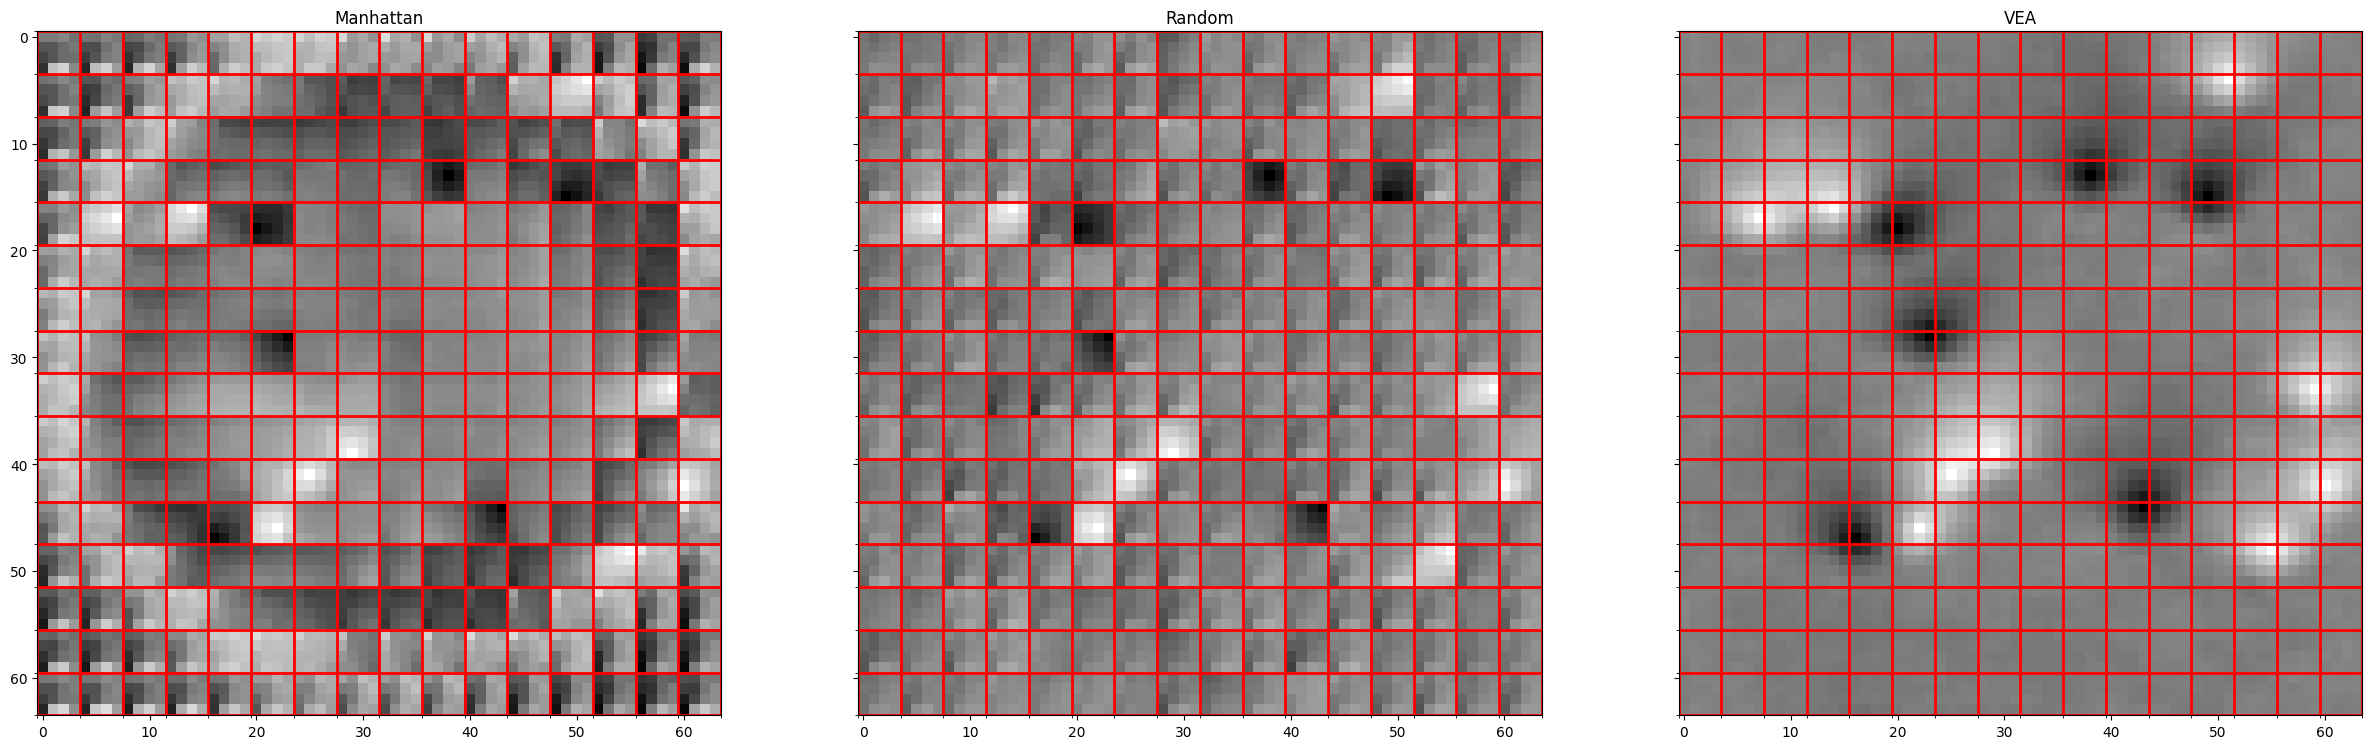

In [ ]:
# Compute the marginal probabilities for each cell in the 1000 realizations
manhattan_marginal_probabilities = np.zeros((64,64))
random_marginal_probabilities = np.zeros((64,64))
VEA_marginal_probabilities = np.zeros((64,64))
for i in range(64):
    for j in range(64):
        manhattan_marginal_probabilities[i,j] = np.mean(cond_images_np[:,i,j])
        random_marginal_probabilities[i,j] = np.mean(cond_images_np_r[:,i,j])
        VEA_marginal_probabilities[i,j] = np.mean(cond_data[:,i,j])

# Plot the marginal probabilities
fig, axs = plt.subplots(1,3, figsize=(30,10))

axs[0].imshow(manhattan_marginal_probabilities, cmap='gray')
# Add gridlines every 4 pixels, there should be 17 lines in each direction
axs[0].set_xticks(np.arange(-.5, 64, 4), minor=True)
axs[0].set_yticks(np.arange(-.5, 64, 4), minor=True)
axs[0].grid(which='minor', color='r', linestyle='-', linewidth=2)
axs[0].set_title('Manhattan')
axs[1].imshow(random_marginal_probabilities, cmap='gray')
axs[1].set_xticks(np.arange(-.5, 64, 4), minor=True)
axs[1].set_yticks(np.arange(-.5, 64, 4), minor=True)
axs[1].grid(which='minor', color='r', linestyle='-', linewidth=2)
axs[1].set_title('Random')
axs[2].imshow(VEA_marginal_probabilities, cmap='gray')
axs[2].set_xticks(np.arange(-.5, 64, 4), minor=True)
axs[2].set_yticks(np.arange(-.5, 64, 4), minor=True)
axs[2].grid(which='minor', color='r', linestyle='-', linewidth=2)
axs[2].set_title('VEA')
for ax in axs.flat:
    ax.label_outer()
plt.show()

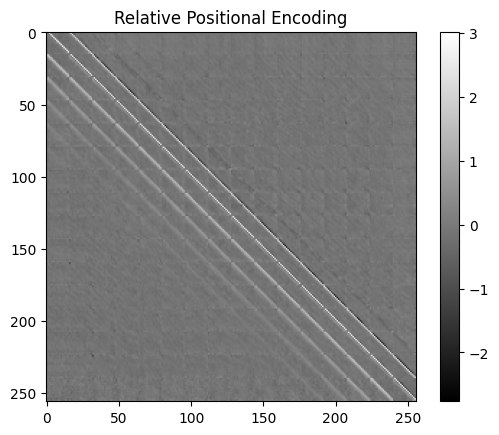

In [ ]:
plt.imshow(model.rel_bias.cpu().detach().numpy(),cmap='gray')
plt.colorbar()
plt.title("Relative Positional Encoding")
plt.show()

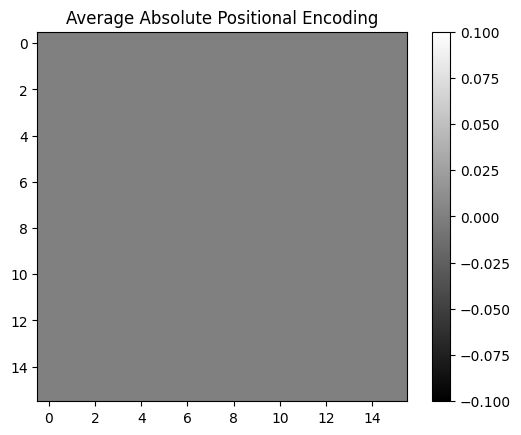

In [ ]:
pos_emb_avg = np.mean(model_wo_PE.pos_emb.cpu().detach().numpy(),axis=1)
pos_emb_avg = pos_emb_avg.reshape(16,16)
plt.imshow(pos_emb_avg,cmap='gray')
plt.colorbar()
plt.title("Average Absolute Positional Encoding")
plt.show()

In [ ]:
# Make list of list to numpy
ll_np = np.array(ll_list)
ll_np = ll_np.reshape(-1)
print(ll_np.shape)
np.save("ll_manhattan.npy",ll_np)

(1000,)


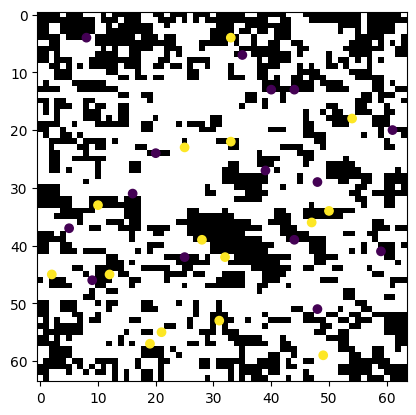

In [ ]:
print(cond_images_np.shape)
plt.imshow(cond_images[5],cmap="gray")
plt.scatter(condition_indices_y,condition_indices_x,c=condition_values,cmap='viridis')
plt.show()

In [ ]:
cond_images,lls = generate_images_batch_method1(model,patch_size,image_size=H,batch_size=10,device=device,condition_indices=condition_indices,condition_values=condition_values)

In [ ]:
final_img, ll = generate_video_method1(
    model, patch_size, W,
    condition_indices=condition_indices,
    condition_values=condition_values,
    topk=16, log_frequency=1,
    video_filename="method1.mp4", fps=4
)

Method1 sampling:  72%|███████▏  | 714/994 [07:00<03:45,  1.24it/s]

In [ ]:
manhattan_order = torch.stack(manhattan_order)
raster_order = torch.stack(raster_order)
random_order = torch.stack(random_order)
manhattan_order = manhattan_order.cpu().detach().numpy()
raster_order = raster_order.cpu().detach().numpy()
random_order = random_order.cpu().detach().numpy()

In [ ]:
import io
import math
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
import imageio

# Ensure you import this from wherever you defined it:
# from ViT import patches_to_image

def fig_to_np(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    return np.array(Image.open(buf).convert("RGB"))

def add_colored_border(token, border_width=1, border_color=(1, 0, 0)):
    token_rgb = np.stack([token] * 3, axis=-1)
    H, W, _ = token_rgb.shape
    new_H, new_W = H + 2 * border_width, W + 2 * border_width
    bordered = np.ones((new_H, new_W, 3)) * 0.5
    bordered[border_width:border_width + H, border_width:border_width + W, :] = token_rgb
    bordered[:border_width, :, :] = border_color
    bordered[-border_width:, :, :] = border_color
    bordered[:, :border_width, :] = border_color
    bordered[:, -border_width:, :] = border_color
    return bordered

def generate_video_method1(
    model,
    patch_size,
    image_size,
    condition_indices=None,
    condition_values=None,
    topk=10,
    log_frequency=20,
    video_filename="generation_method1.mp4",
    fps=4
):
    """
    Method1: 'sample-all-then-select' video generator with 4-panel logging.
    """
    device = next(model.parameters()).device
    model.eval()

    grid_size     = image_size // patch_size
    total_patches = grid_size * grid_size
    patch_dim     = patch_size * patch_size

    # 1) Initialize all patches to mask token
    generated_patches = (
        model.mask_token.detach().to(device)
        .unsqueeze(0)             # [1, patch_dim]
        .expand(total_patches, patch_dim)
        .clone()
    )
    sampled_flags = torch.zeros(total_patches, dtype=torch.bool, device=device)

    # 2) Build conditioning dict
    conditions_by_patch = {}
    if condition_indices is not None and condition_values is not None:
        for pix_idx, pix_val in zip(condition_indices, condition_values):
            r, c = divmod(pix_idx, image_size)
            pr, pc = r // patch_size, c // patch_size
            pidx = pr * grid_size + pc
            local = (r % patch_size) * patch_size + (c % patch_size)
            conditions_by_patch.setdefault(pidx, []).append((local, pix_val))

    log_likelihood_sum = 0.0
    frames_list        = []
    condition_cmap     = ListedColormap(["blue", "red"])
    update_step        = 0

    # ——— Fill observed patches first ———
    if conditions_by_patch:
        with torch.no_grad():
            logits_obs, _ = model(generated_patches.unsqueeze(0), mask_rate=0.0)  # [1, P, V]

        for pidx in sorted(conditions_by_patch):
            # Filter logits under conditioning
            lc = logits_obs[0, pidx].clone()
            valid = torch.ones(model.vocab_size, device=device, dtype=torch.bool)
            for local, val in conditions_by_patch[pidx]:
                valid &= (model.vocab[:, local].to(device) == val)
            lc[~valid] = -float('inf')

            # Sample
            probs = F.softmax(lc, dim=-1)
            samp  = torch.multinomial(probs, 1).item()
            lp    = math.log(probs[samp].item() + 1e-10)
            log_likelihood_sum += lp

            # Update
            generated_patches[pidx] = model.vocab[samp].to(device)
            sampled_flags[pidx]     = True

            # Log a frame
            if update_step % log_frequency == 0:
                fig, axes = plt.subplots(1, 4, figsize=(28, 7))

                # Panel 1: Current Image
                display_patches = []
                for i in range(total_patches):
                    if sampled_flags[i]:
                        display_patches.append(generated_patches[i])
                    else:
                        display_patches.append(torch.full((patch_dim,), 0.5, device=device))
                disp_t = torch.stack(display_patches)
                curr_img = patches_to_image(disp_t, (image_size, image_size), patch_size)
                axes[0].imshow(curr_img.cpu().numpy(), cmap="gray", vmin=0, vmax=1)
                if condition_indices is not None:
                    xs = condition_indices // image_size
                    ys = condition_indices % image_size
                    axes[0].scatter(ys, xs, c=condition_values, cmap=condition_cmap, s=20, edgecolors="white")
                row0 = (pidx // grid_size) * patch_size
                col0 = (pidx % grid_size) * patch_size
                axes[0].add_patch(mpatches.Rectangle(
                    (col0 - .5, row0 - .5), patch_size, patch_size,
                    linewidth=2, edgecolor="green", facecolor="none"))
                axes[0].set_title(f"Step {update_step}: patch {pidx}")
                axes[0].axis("off")

                # Panel 2: Probabilities bar
                top_vals, top_inds = torch.topk(probs, topk)
                axes[1].bar(range(topk), top_vals.cpu().numpy())
                axes[1].set_xticks(range(topk))
                axes[1].set_xticklabels(top_inds.cpu().numpy())
                axes[1].set_ylim(0, 1)
                axes[1].set_title("Token Probabilities")

                # Panel 3: Top-k token images
                token_imgs = []
                for tidx in top_inds:
                    tok = model.vocab[tidx].detach().cpu().view(patch_size, patch_size).numpy()
                    token_imgs.append(add_colored_border(tok, border_width=1))
                axes[2].imshow(np.hstack(token_imgs), cmap="gray", vmin=0, vmax=1)
                axes[2].axis("off")
                axes[2].set_title("Top-k Tokens")

                # Panel 4: Argmax reconstruction
                recon_ids    = torch.argmax(logits_obs[0], dim=-1)
                recon_patches = model.vocab[recon_ids]
                recon_img     = patches_to_image(recon_patches, (image_size, image_size), patch_size)
                axes[3].imshow(recon_img.cpu().numpy(), cmap="gray", vmin=0, vmax=1)
                axes[3].set_title("Argmax Recon")
                axes[3].axis("off")

                plt.suptitle(f"Filling observed patch {pidx}")
                composite = fig_to_np(fig)
                plt.close(fig)
                frames_list.append(composite)

            update_step += 1

    # ——— Now dynamically fill remaining patches via Method 1 ———
    to_fill = total_patches - sampled_flags.sum().item()
    for _ in tqdm(range(to_fill), desc="Method1 sampling"):
        with torch.no_grad():
            logits_full, _ = model(generated_patches.unsqueeze(0), mask_rate=0.0)  # [1, P, V]

        # Sample one token per patch
        flat_logits   = logits_full[0].view(total_patches, model.vocab_size)  # [P, V]
        flat_probs    = F.softmax(flat_logits, dim=-1)
        flat_samps    = torch.multinomial(flat_probs, 1).squeeze(-1)            # [P]
        flat_maxprob  = flat_probs[torch.arange(total_patches, device=device), flat_samps]
        flat_maxprob[sampled_flags] = -float('inf')

        # Pick the patch with highest sampled-prob
        pidx = torch.argmax(flat_maxprob).item()

        # Filter logits_cur if conditioned
        logits_cur = logits_full[0, pidx].clone()
        if pidx in conditions_by_patch:
            vm = torch.ones(model.vocab_size, device=device, dtype=torch.bool)
            for local, val in conditions_by_patch[pidx]:
                vm &= (model.vocab[:, local].to(device) == val)
            logits_cur[~vm] = -float('inf')
        probs_cur = F.softmax(logits_cur, dim=-1)

        # Sample and accumulate log‐lik
        chosen = flat_samps[pidx].item()
        lp     = math.log(probs_cur[chosen].item() + 1e-10)
        log_likelihood_sum += lp

        # Update
        generated_patches[pidx] = model.vocab[chosen].to(device)
        sampled_flags[pidx]     = True

        # Log a frame
        if update_step % log_frequency == 0:
            fig, axes = plt.subplots(1, 4, figsize=(28, 7))

            # Panel 1: Current Image
            display_patches = []
            for i in range(total_patches):
                if sampled_flags[i]:
                    display_patches.append(generated_patches[i])
                else:
                    display_patches.append(torch.full((patch_dim,), 0.5, device=device))
            disp_t = torch.stack(display_patches)
            curr_img = patches_to_image(disp_t, (image_size, image_size), patch_size)
            axes[0].imshow(curr_img.cpu().numpy(), cmap="gray", vmin=0, vmax=1)
            if condition_indices is not None:
                xs = condition_indices // image_size
                ys = condition_indices % image_size
                axes[0].scatter(ys, xs, c=condition_values, cmap=condition_cmap, s=20, edgecolors="white")
            row0 = (pidx // grid_size) * patch_size
            col0 = (pidx % grid_size) * patch_size
            axes[0].add_patch(mpatches.Rectangle(
                (col0 - .5, row0 - .5), patch_size, patch_size,
                linewidth=2, edgecolor="green", facecolor="none"))
            axes[0].set_title(f"Step {update_step}: patch {pidx}")
            axes[0].axis("off")

            # Panel 2: Bar plot of probs_cur
            top_vals, top_inds = torch.topk(probs_cur, topk)
            axes[1].bar(range(topk), top_vals.cpu().numpy())
            axes[1].set_xticks(range(topk))
            axes[1].set_xticklabels(top_inds.cpu().numpy())
            axes[1].set_ylim(0, 1)
            axes[1].set_title("Token Probabilities")

            # Panel 3: Top-k token images
            token_imgs = []
            for tidx in top_inds:
                tok = model.vocab[tidx].detach().cpu().view(patch_size, patch_size).numpy()
                token_imgs.append(add_colored_border(tok, border_width=1))
            axes[2].imshow(np.hstack(token_imgs), cmap="gray", vmin=0, vmax=1)
            axes[2].axis("off")
            axes[2].set_title("Top-k Tokens")

            # Panel 4: Argmax reconstruction from logits_full
            recon_ids     = torch.argmax(logits_full[0], dim=-1)
            recon_patches = model.vocab[recon_ids]
            recon_img     = patches_to_image(recon_patches, (image_size, image_size), patch_size)
            axes[3].imshow(recon_img.cpu().numpy(), cmap="gray", vmin=0, vmax=1)
            axes[3].set_title("Argmax Recon")
            axes[3].axis("off")

            plt.suptitle(f"Filling patch {pidx}")
            composite = fig_to_np(fig)
            plt.close(fig)
            frames_list.append(composite)

        update_step += 1

    # Final image (unsampled→0.5)
    display = torch.where(
        sampled_flags.unsqueeze(-1),
        generated_patches,
        torch.full((total_patches, patch_dim), 0.5, device=device)
    )
    final_img = patches_to_image(display, (image_size, image_size), patch_size)

    # Save video
    imageio.mimwrite(video_filename, frames_list, fps=fps)
    print(f"Saved Method1 video to {video_filename}")

    return final_img, log_likelihood_sum

In [ ]:
import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
import imageio

def add_colored_border(token, border_width=1, border_color=(1, 0, 0)):
    """
    Convert a 2D token image (grayscale, values in [0,1]) to a 3-channel RGB image,
    and add a border of specified width and color.

    Args:
        token: numpy 2D array of shape (patch_size, patch_size).
        border_width: width (in pixels) of the border.
        border_color: tuple (R, G, B) with values in [0, 1] for the border color.

    Returns:
        token_with_border: numpy array of shape (patch_size+2*border_width, patch_size+2*border_width, 3).
    """
    # Convert token to RGB by stacking along the last dimension.
    token_rgb = np.stack([token] * 3, axis=-1)
    H, W, _ = token_rgb.shape
    new_H, new_W = H + 2 * border_width, W + 2 * border_width
    # Initialize a new image with a gray background (0.5).
    bordered = np.ones((new_H, new_W, 3)) * 0.5
    # Place the token in the center.
    bordered[border_width:border_width + H, border_width:border_width + W, :] = token_rgb
    # Set borders to the given border color.
    bordered[:border_width, :, :] = border_color
    bordered[-border_width:, :, :] = border_color
    bordered[:, :border_width, :] = border_color
    bordered[:, -border_width:, :] = border_color
    return bordered

def fig_to_np(fig):
    """Convert a Matplotlib figure to a NumPy array in RGB."""
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    return np.array(img)

def generate_video(model, patch_size, image_size, condition_indices=None, condition_values=None,
                   topk=10, log_frequency=20, video_filename="generation.mp4", fps=4):
    """
    Generate an image conditionally while producing composite frames that are later combined into an MP4 video.

    For each logged generation step (every log_frequency updates), a composite figure with 4 subplots is created:
      1. Current image: unsampled patches appear as uniform gray (0.5). Observed condition points are overlaid
         with small scatter markers (blue for 0, red for 1), and the patch to be updated is highlighted by a green rectangle.
      2. A bar plot (with fixed axis limits) of the normalized token probabilities (if the patch has conditions, the filtered distribution is used).
      3. The top-k candidate tokens displayed as small images (side by side), in the same order as the bar plot.
      4. The deterministic reconstruction of the full image (obtained by taking argmax over logits for every patch).

    At the end, all composite frames are saved into a video file.

    Args:
        model: The trained ViT model. Assumes model.vocab is of shape [vocab_size, patch_dim] and model.mask_token is [patch_dim].
        patch_size: Side length (in pixels) of each patch (e.g., 2).
        image_size: Side length (in pixels) of the full image.
        condition_indices: (Optional) List/array of flattened indices for observed cells.
        condition_values: (Optional) Corresponding observed cell values (0 or 1).
        topk: Number of top candidates to display in the token bar plot and token images.
        log_frequency: Log a composite frame every this many patch updates.
        video_filename: Output video filename.
        fps: Frames per second for the output video.

    Returns:
        final_generated_image: The final generated image tensor.
        log_likelihood_sum: The total accumulated log-probability.
    """
    device = next(model.parameters()).device
    model.eval()

    grid_size = image_size // patch_size  # assume divisible
    total_patches = grid_size * grid_size
    patch_dim = patch_size * patch_size

    # Initialize generated patches with the model's mask token.
    generated_patches = model.mask_token.expand(total_patches, patch_dim).clone().to(device)
    # We keep a boolean flag for whether a patch has been sampled.
    sampled_flags = torch.zeros(total_patches, dtype=torch.bool, device=device)

    # Build mapping from patch index to list of (local_index, observed_value).
    conditions_by_patch = {}
    if (condition_indices is not None) and (condition_values is not None):
        for cond_idx, cond_val in zip(condition_indices, condition_values):
            pixel_row = cond_idx // image_size
            pixel_col = cond_idx % image_size
            patch_row = pixel_row // patch_size
            patch_col = pixel_col // patch_size
            patch_idx = patch_row * grid_size + patch_col
            local_idx = (pixel_row % patch_size) * patch_size + (pixel_col % patch_size)
            conditions_by_patch.setdefault(patch_idx, []).append((local_idx, cond_val))

    # Determine sampling order: observed patches first, then unobserved sorted by Manhattan distance.
    observed_patch_ids = sorted(list(conditions_by_patch.keys()))
    all_patch_indices = set(range(total_patches))
    for pid in observed_patch_ids:
        all_patch_indices.discard(pid)
    distance_list = []
    for p in all_patch_indices:
        row = p // grid_size
        col = p % grid_size
        dist_sum = sum(abs(row - (op // grid_size)) + abs(col - (op % grid_size)) for op in observed_patch_ids)
        distance_list.append((p, dist_sum))
    distance_list.sort(key=lambda x: x[1])
    unobserved_patch_ids = [p for p, _ in distance_list]
    sampling_order = observed_patch_ids + unobserved_patch_ids

    log_likelihood_sum = 0.0
    frames_list = []  # To collect composite frames for the video

    # Define a two-color colormap for condition scatter: blue=0, red=1.
    condition_cmap = ListedColormap(["blue", "red"])

    # Generation loop (using tqdm progress bar)
    for idx, patch_idx in enumerate(tqdm(sampling_order, desc="Sampling patches")):
        current_tokens = generated_patches.unsqueeze(0).clone()  # [1, total_patches, patch_dim]
        with torch.no_grad():
            logits_full, _ = model(current_tokens, mask_rate=0.0)  # [1, total_patches, vocab_size]
        logits_current = logits_full[0, patch_idx]  # [vocab_size]

        # Compute normalized probabilities (if patch has conditions, use filtered).
        probs_unfiltered = F.softmax(logits_current, dim=-1)
        if patch_idx in conditions_by_patch:
            valid_mask = torch.ones(model.vocab.shape[0], dtype=torch.bool, device=device)
            for local_idx, cond_val in conditions_by_patch[patch_idx]:
                valid_mask &= (model.vocab[:, local_idx] == cond_val)
            logits_filtered = logits_current.clone()
            logits_filtered[~valid_mask] = -float("inf")
            probs_norm = F.softmax(logits_filtered, dim=-1)
        else:
            probs_norm = probs_unfiltered.clone()

        # ---- Create Composite Figure for this step ----
        fig, axes = plt.subplots(1, 4, figsize=(28, 7))

        # (1) Current Image: Build a display image with unsampled patches forced to 0.5.
        display_patches = []
        for i in range(total_patches):
            if sampled_flags[i]:
                display_patches.append(generated_patches[i])
            else:
                display_patches.append(torch.full((patch_dim,), 0.5, device=device))
        display_tensor = torch.stack(display_patches)
        current_img = patches_to_image(display_tensor, (image_size, image_size), patch_size)
        axes[0].imshow(current_img.cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1)
        # Overlay a scatter plot for conditions.
        if condition_indices is not None and condition_values is not None:
            cond_x = condition_indices // image_size
            cond_y = condition_indices % image_size
            axes[0].scatter(cond_y, cond_x, c=condition_values, cmap=condition_cmap, s=20, edgecolors="white")
        # Draw a green rectangle around the patch being updated.
        row_coord = (patch_idx // grid_size) * patch_size
        col_coord = (patch_idx % grid_size) * patch_size
        axes[0].add_patch(mpatches.Rectangle((col_coord - 0.5, row_coord - 0.5), patch_size, patch_size,
                                             linewidth=2, edgecolor="green", facecolor="none"))
        axes[0].set_title(f"Current Image (Patch {patch_idx} highlighted)")
        axes[0].axis("off")

        # (2) Bar Plot of Normalized Probabilities.
        top_vals, top_inds = torch.topk(probs_norm, k=topk)
        axes[1].bar(range(topk), top_vals.cpu().numpy(), color="purple")
        axes[1].set_xticks(range(topk))
        axes[1].set_xticklabels(top_inds.cpu().numpy())
        axes[1].set_ylabel("Probability")
        axes[1].set_title(f"Normalized Probabilities (Patch {patch_idx})")
        axes[1].set_ylim([0, 1])

        # (3) Token Patches: Display the top-k tokens as small images (side-by-side).
        token_imgs = []
        for idx in top_inds:
            token = model.vocab[idx].detach().cpu().reshape(patch_size, patch_size).numpy()
            # Add a colored border (here red) with a 1-pixel border:
            token_with_border = add_colored_border(token, border_width=1, border_color=(1, 0, 0))
            token_imgs.append(token_with_border)
        # Concatenate the bordered token images horizontally.
        token_grid = np.hstack(token_imgs)
        axes[2].imshow(token_grid, cmap="gray", vmin=0, vmax=1)
        axes[2].set_title("Top-k Token Candidates (with red border)")
        axes[2].axis("off")

        # (4) Deterministic Reconstruction: argmax across all patches.
        recon_tokens = torch.argmax(logits_full, dim=-1)[0]
        recon_patches = model.vocab[recon_tokens]
        recon_img = patches_to_image(recon_patches, (image_size, image_size), patch_size)
        axes[3].imshow(recon_img.cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1)
        axes[3].set_title("Deterministic Reconstruction")
        axes[3].axis("off")

        plt.suptitle(f"Generation Step {idx}, Updating Patch {patch_idx}")
        composite_frame = fig_to_np(fig)
        plt.close(fig)

        # ----- End Composite Figure Creation -----

        # Append this composite frame if we are logging at this interval.
        if idx % log_frequency == 0:
            frames_list.append(composite_frame)

        # ----- Sampling Step -----
        final_probs = probs_norm  # use normalized probabilities (filtered if applicable)
        sampled_idx = torch.multinomial(final_probs, num_samples=1).item()
        lp = torch.log(final_probs[sampled_idx] + 1e-10).item()
        log_likelihood_sum += lp
        generated_patches[patch_idx] = model.vocab[sampled_idx]
        sampled_flags[patch_idx] = True

    # After finishing generation, construct the final image (unsampled -> 0.5).
    final_display = []
    for i in range(total_patches):
        if sampled_flags[i]:
            final_display.append(generated_patches[i])
        else:
            final_display.append(torch.full((patch_dim,), 0.5, device=device))
    final_tensor = torch.stack(final_display)
    final_generated_image = patches_to_image(final_tensor, (image_size, image_size), patch_size)

    # Save video using imageio.
    import imageio
    imageio.mimwrite(video_filename, frames_list, fps=fps)
    print(f"Video saved as {video_filename}")

    return final_generated_image, log_likelihood_sum

In [ ]:
final_img, total_logp = generate_video(model, patch_size, W,
                                                     flattened_condition_indices,
                                                     condition_values_new,
                                                     topk=10, log_frequency=1,video_filename="conditional_generation.mp4",fps=4)

Sampling patches: 100%|██████████| 256/256 [01:32<00:00,  2.76it/s]


Video saved as conditional_generation.mp4


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import wandb
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

########################################
# Helper: Convert Patches to Integer Code
########################################

def patch_to_int(patches):
    """
    Converts a tensor of patches (shape: [N, patch_dim]) containing binary values
    to an integer code. Assumes values are near 0 or 1.
    """
    patches_bin = patches.round().long()  # ensure binary
    patch_dim = patches_bin.shape[1]
    powers = (2 ** torch.arange(patch_dim - 1, -1, -1, device=patches.device)).unsqueeze(0)
    codes = (patches_bin * powers).sum(dim=1)
    return codes

########################################
# Helper: Image Sampling (Conditional)
########################################

def sample_image_conditional(model, patch_size, image_size, temperature=1.0,
                             condition_indices=None, condition_values=None):
    """
    Generate one image using the autoregressive model while enforcing conditions.
    Instead of a fixed raster-scan order, this function first generates the patches
    that contain condition values and then fills in the rest in order of increasing
    Manhattan distance from any conditioned patch.

    Returns:
      - generated: a tensor of shape (1, num_patches, patch_dim)
      - log_likelihood: the sum of log-probabilities for the sampled tokens.
    """
    num_patches = (image_size // patch_size) ** 2
    patch_dim = patch_size * patch_size
    grid_size = image_size // patch_size

    # Build patch-level conditions: a dictionary mapping patch index -> {local index: condition value}
    patch_conditions = {}
    if condition_indices is not None and condition_values is not None:
        for cond_idx, cond_val in zip(condition_indices, condition_values):
            global_row = int(cond_idx) // image_size
            global_col = int(cond_idx) % image_size
            patch_row = global_row // patch_size
            patch_col = global_col // patch_size
            patch_index = patch_row * grid_size + patch_col
            local_row = global_row % patch_size
            local_col = global_col % patch_size
            local_index = local_row * patch_size + local_col
            if patch_index not in patch_conditions:
                patch_conditions[patch_index] = {}
            patch_conditions[patch_index][local_index] = float(cond_val)

    # Define a helper to compute patch coordinates.
    def patch_coords(i):
        return (i // grid_size, i % grid_size)

    # Determine generation order.
    # First, the conditioned patch indices (those that appear in patch_conditions).
    conditioned_indices = set(patch_conditions.keys())
    conditioned_list = sorted(list(conditioned_indices))

    # Then, the remaining indices sorted by minimum Manhattan distance to any conditioned patch.
    remaining = [i for i in range(num_patches) if i not in conditioned_indices]
    def min_distance(i):
        r_i, c_i = patch_coords(i)
        # If no conditioned patch, return a high number.
        return min(abs(r_i - patch_coords(j)[0]) + abs(c_i - patch_coords(j)[1])
                   for j in conditioned_indices) if conditioned_indices else 0
    remaining = sorted(remaining, key=min_distance)

    # Final generation order: first fill in conditioned patches, then the rest.
    order_list = conditioned_list + remaining

    # Initialize generated patches with the learnable mask token.
    generated = model.mask_token.detach().clone().unsqueeze(0).repeat(num_patches, 1)
    log_likelihood = 0.0
    # Add a batch dimension.
    generated = generated.unsqueeze(0)  # shape: (1, num_patches, patch_dim)

    # Generate patches in the determined order.
    for idx in order_list:
        # Optionally, if this patch has a condition, restrict candidates.
        cond = patch_conditions.get(idx, None)
        # Compute logits for the entire sequence.
        logits = model(generated)  # shape: (1, num_patches, vocab_size)
        logits_i = logits[0, idx] / temperature
        if cond is not None:
            candidate_mask = torch.ones(model.vocab_size, dtype=torch.bool, device=logits_i.device)
            for local_idx, cond_val in cond.items():
                candidate_mask = candidate_mask & (model.vocab[:, local_idx] == cond_val)
            logits_i = logits_i.masked_fill(~candidate_mask, -1e9)
        probs = torch.softmax(logits_i, dim=-1)
        token = torch.multinomial(probs, num_samples=1)
        log_prob = torch.log(probs[token] + 1e-10)
        log_likelihood += log_prob.item()
        patch = model.vocab[token]
        generated[0, idx] = patch

    return generated, log_likelihood

########################################
# Vision Transformer and Transformer Encoder Layer
########################################

class VisionTransformer(nn.Module):
    def __init__(self, num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, ffn_dim, dropout)
            for _ in range(num_layers)
        ])
        self.dropout_layer = nn.Dropout(dropout)

    def build_vocabulary(self, training_data, patch_size, full_mask=True, one_mask=True):
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size
        H, W = training_data.shape[1], training_data.shape[2]
        num_patches = (H // patch_size) * (W // patch_size)
        patches_tensor = training_data.unfold(1, patch_size, patch_size)\
                                        .unfold(2, patch_size, patch_size)
        patches_tensor = patches_tensor.contiguous().view(-1, patch_dim)
        unique_set = set()
        unique_list = []
        for patch in tqdm(patches_tensor, desc=f"Building Vocabulary for {patch_size}x{patch_size}", total=patches_tensor.shape[0]):
            patch_cpu = patch.cpu()
            patch_tuple = tuple(patch_cpu.tolist())
            if patch_tuple not in unique_set:
                unique_set.add(patch_tuple)
                unique_list.append(patch_cpu)
        if full_mask:
            unique_list.append(torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu'))
        if one_mask:
            for i in range(patch_dim):
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 0.0
                unique_list.append(mask_patch)
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 1.0
                unique_list.append(mask_patch)
        self.vocab = torch.stack(unique_list)
        self.vocab_size = self.vocab.size(0)
        self.vocab_int = patch_to_int(self.vocab)
        self.embedding_projection = nn.Linear(patch_dim, self.hidden_dim)
        self.output_projection = nn.Linear(self.hidden_dim, self.vocab_size)
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches, self.hidden_dim))
        self.mask_token = nn.Parameter(torch.full((patch_dim,), 0.5, dtype=torch.float))
        return self.vocab

    def forward(self, patches):
        # patches: (B, num_patches, patch_dim)
        B, num_patches, _ = patches.shape
        embeddings = self.embedding_projection(patches)
        embeddings = embeddings + self.pos_embedding[:, :num_patches, :]
        z = self.dropout_layer(embeddings)
        for layer in self.transformer_layers:
            z = layer(z)
        logits = self.output_projection(z)  # (B, num_patches, vocab_size)
        return logits

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, ffn_dim, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(hidden_dim, ffn_dim)
        self.linear2 = nn.Linear(ffn_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, z):
        z_norm = self.norm1(z)
        z_t = z_norm.transpose(0, 1)
        attn_output, _ = self.self_attn(z_t, z_t, z_t)
        attn_output = attn_output.transpose(0, 1)
        z = z + self.dropout1(attn_output)
        z_norm = self.norm2(z)
        ff_output = self.linear2(self.dropout2(self.activation(self.linear1(z_norm))))
        z = z + self.dropout2(ff_output)
        return z

########################################
# Dataset and Patch Extraction
########################################

class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images  # shape: (N, H, W)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        return self.images[idx]
    @staticmethod
    def batch_to_patches(images, patch_size):
        B, H, W = images.shape
        patches = images.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.contiguous().view(B, -1, patch_size * patch_size)
        return patches
    @staticmethod
    def patches_to_image(patches, patch_size, image_size):
        # patches: (num_patches, patch_dim) ordered in raster scan.
        image = torch.zeros(image_size, image_size, device=patches.device)
        idx = 0
        for i in range(0, image_size, patch_size):
            for j in range(0, image_size, patch_size):
                image[i:i+patch_size, j:j+patch_size] = patches[idx].view(patch_size, patch_size)
                idx += 1
        return image

########################################
# Training Pipeline (Loss only on masked tokens)
########################################

def train_model_for_patch(patch_size, training_data, start_epoch=0, total_epochs=1000, batch_size=128, checkpoint_path=None):
    # Increased model capacity.
    num_heads = 8
    num_layers = 8
    ffn_dim = 1024
    hidden_dim = 256

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    training_data = training_data.to(device)
    image_size = training_data.shape[1]

    # Initialize wandb with updated total_epochs and a name reflecting the resumed run.
    wandb.init(project="vision-transformer-comparison",
               config={
                   "num_heads": num_heads,
                   "num_layers": num_layers,
                   "ffn_dim": ffn_dim,
                   "hidden_dim": hidden_dim,
                   "patch_size": patch_size,
                   "start_epoch": start_epoch,
                   "total_epochs": total_epochs,
                   "batch_size": batch_size
               },
               name=f"patch_{patch_size}x{patch_size}_epochs{start_epoch+1}-{total_epochs}",
               reinit=True)

    model = VisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.1)
    model.build_vocabulary(training_data, patch_size)
    model = model.to(device)
    model.vocab = model.vocab.to(device)
    model.vocab_int = patch_to_int(model.vocab).to(device)

    # --- RESUME: Load checkpoint if provided ---
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint)
        print(f"Loaded checkpoint from {checkpoint_path}")

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    dataset = BinaryImageDataset(training_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # --- Training loop from start_epoch to total_epochs ---
    for epoch in range(start_epoch, total_epochs):
        model.train()
        total_loss = 0.0

        # Gradual mask schedule based on the global epoch number.
        num_patches = (image_size // patch_size) ** 2
        min_mask_rate = 1.0 / num_patches
        # The mask rate increases gradually from a single masked patch (min_mask_rate)
        # to a fully masked image (1.0) over total_epochs.
        base_mask_rate = min_mask_rate + (1.0 - min_mask_rate) * (epoch / total_epochs)
        mask_rate = np.clip(base_mask_rate + np.random.uniform(-0.1, 0.1), min_mask_rate, 1.0)
        partial_mask_rate = 0.3  # Keep the partially masked rate constant.

        epoch_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{total_epochs} (patch {patch_size}x{patch_size})", leave=False)
        for batch in epoch_bar:
            batch = batch.to(device)
            B = batch.shape[0]
            patches = BinaryImageDataset.batch_to_patches(batch, patch_size)  # (B, num_patches, patch_dim)
            patch_dim = patches.shape[2]

            # Create mask for each patch (only masked tokens contribute to loss).
            mask = torch.rand(B, num_patches, device=device) < mask_rate
            mask[:, 0] = True

            partial = (torch.rand(B, num_patches, device=device) < partial_mask_rate) & mask
            full = mask & (~partial)

            masked_patches = patches.clone()
            if full.any():
                masked_patches[full] = model.mask_token
            if partial.any():
                partial_idx = torch.nonzero(partial)
                num_partial = partial_idx.shape[0]
                new_patches = torch.full((num_partial, patch_dim), 0.5, device=device)
                rand_positions = torch.randint(0, patch_dim, (num_partial,), device=device)
                orig_vals = patches[partial_idx[:, 0], partial_idx[:, 1], :].gather(1, rand_positions.unsqueeze(1)).squeeze(1)
                new_patches[torch.arange(num_partial), rand_positions] = orig_vals
                masked_patches[partial_idx[:, 0], partial_idx[:, 1]] = new_patches

            # Forward pass.
            logits = model(masked_patches)  # (B, num_patches, vocab_size)

            # Compute targets over all patches.
            all_patches = patches.view(B * num_patches, patch_dim)
            codes = patch_to_int(all_patches)
            vocab_codes = model.vocab_int
            mask_eq = codes.unsqueeze(1) == vocab_codes.unsqueeze(0)
            target_indices = mask_eq.float().argmax(dim=1)
            targets_all = target_indices.view(B, num_patches)

            # Compute loss only over masked tokens.
            if mask.sum() > 0:
                loss = criterion(logits[mask], targets_all[mask])
            else:
                loss = torch.tensor(0.0, device=device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_bar.set_postfix(loss=loss.item(), mask_rate=mask_rate)
        avg_loss = total_loss / len(dataloader)
        wandb.log({"epoch": epoch, "loss": avg_loss, "mask_rate": mask_rate})
        print(f"[Patch {patch_size}x{patch_size}] Epoch {epoch+1}/{total_epochs}, Loss: {avg_loss:.4f}, Mask Rate: {mask_rate:.2f}")

        # --- Visualization on First Batch (unchanged) ---
        model.eval()
        with torch.no_grad():
            batch0 = next(iter(dataloader)).to(device)
            patches0 = BinaryImageDataset.batch_to_patches(batch0, patch_size)
            B0, num_patches, patch_dim = patches0.shape
            vis_mask = (torch.rand(1, num_patches, device=device) < mask_rate).squeeze(0)
            vis_mask[0] = True
            vis_partial = (torch.rand(1, num_patches, device=device) < partial_mask_rate).squeeze(0) & vis_mask
            vis_full = vis_mask & (~vis_partial)
            masked_vis = patches0[0].clone()
            if vis_full.any():
                masked_vis[vis_full] = model.mask_token
            if vis_partial.any():
                partial_idx_vis = torch.nonzero(vis_partial)
                num_partial_vis = partial_idx_vis.shape[0]
                new_patches_vis = torch.full((num_partial_vis, patch_dim), 0.5, device=device)
                rand_positions_vis = torch.randint(0, patch_dim, (num_partial_vis,), device=device)
                orig_vals_vis = patches0[0, partial_idx_vis[:, 0], :].gather(1, rand_positions_vis.unsqueeze(1)).squeeze(1)
                new_patches_vis[torch.arange(num_partial_vis), rand_positions_vis] = orig_vals_vis
                masked_vis[partial_idx_vis[:, 0]] = new_patches_vis
            logits_vis = model(masked_vis.unsqueeze(0))
            predicted_tokens = torch.argmax(logits_vis, dim=-1).squeeze(0)
            recon_vis = patches0[0].clone()
            recon_vis[vis_mask] = model.vocab[predicted_tokens[vis_mask]]
            masked_img = BinaryImageDataset.patches_to_image(masked_vis, patch_size, image_size)
            recon_img = BinaryImageDataset.patches_to_image(recon_vis, patch_size, image_size)
            original_img = BinaryImageDataset.patches_to_image(patches0[0], patch_size, image_size)
            wandb.log({
                "original": wandb.Image(original_img.cpu()),
                "masked": wandb.Image(masked_img.cpu()),
                "reconstructed": wandb.Image(recon_img.cpu())
            })

        # --- Every 100 Epochs: Conditional Sampling and Saving Checkpoints ---
        if (epoch + 1) % 100 == 0:
            condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,2000,3312,
                                          2953,289,2373,2720,872,2713,1206,1341,3541,2226,3423,1904,
                                          2882,2540,1497,2524,264,1441])
            condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,1,0,1,1,0,1])
            gen, ll = sample_image_conditional(model, patch_size, image_size, temperature=1.0,
                                               condition_indices=condition_indices,
                                               condition_values=condition_values)
            gen_img = BinaryImageDataset.patches_to_image(gen[0], patch_size, image_size)
            wandb.log({"conditional_sample": wandb.Image(gen_img.cpu(), caption=f"LL: {ll:.2f}")})

        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), f"vision_transformer_patch{patch_size}x{patch_size}_epoch{epoch+1}.pth")
    wandb.finish()
    return model

# --- Example of resuming training ---
"""
if __name__ == "__main__":
    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
    training_data = arr[:9000]
    training_data = training_data.reshape(-1, 64, 64)
    print("Training data shape:", training_data.shape)
    training_data = torch.tensor(training_data, dtype=torch.float32)
    patch_size = 4

    # Resume training from epoch 800 for an additional 500 epochs (total_epochs = 1300).
    model = train_model_for_patch(patch_size, training_data, start_epoch=800, total_epochs=1300,
                                  checkpoint_path="vision_transformer_patch4x4_epoch800 (1).pth")
"""

'\nif __name__ == "__main__":\n    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]\n    training_data = arr[:9000]\n    training_data = training_data.reshape(-1, 64, 64)\n    print("Training data shape:", training_data.shape)\n    training_data = torch.tensor(training_data, dtype=torch.float32)\n    patch_size = 4\n\n    # Resume training from epoch 800 for an additional 500 epochs (total_epochs = 1300).\n    model = train_model_for_patch(patch_size, training_data, start_epoch=800, total_epochs=1300,\n                                  checkpoint_path="vision_transformer_patch4x4_epoch800 (1).pth")\n'

In [ ]:
# Parameters.
patch_size = 4
image_size = 64  # note: training images are 64x64 now (adjust if needed)

# Provided condition indices and values (global pixel indices over a flattened 64x64 image)
condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,
                                2000,3312,2953,289,2373,2720,872,2713,1206,1341,
                                3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,
                               1,1,1,0,1,0,1,1,0,1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build the model architecture with the same hyperparameters as training.
num_heads = 8
num_layers = 8
ffn_dim = 1024
hidden_dim = 256
dropout = 0.1

model = VisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout)

arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
training_data = arr[:9000]
training_data = training_data.reshape(-1, 64, 64)  # 60x60 images; adjust if needed.
print("Training data shape:", training_data.shape)
training_data = torch.tensor(training_data, dtype=torch.float32)
# Load the saved vocabulary so that the output projection has the correct dimensions.
vocab = model.build_vocabulary(training_data,patch_size)
model.vocab = vocab.to(device)
model.vocab_int = patch_to_int(model.vocab).to(device)
# Rebuild the output projection to match the vocab size.
model.output_projection = nn.Linear(model.hidden_dim, model.vocab.size(0)).to(device)
model = model.to(device)
checkpoint_dir = ""
epoch = 1100
ckpt_path = os.path.join(checkpoint_dir, f"vision_transformer_patch{patch_size}x{patch_size}_epoch{epoch}.pth")
print(f"Loading checkpoint: {ckpt_path}")
state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

Training data shape: (9000, 64, 64)


Building Vocabulary for 4x4: 100%|██████████| 2304000/2304000 [00:10<00:00, 211129.36it/s]


Loading checkpoint: vision_transformer_patch4x4_epoch1100.pth


VisionTransformer(
  (transformer_layers): ModuleList(
    (0-7): 8 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (activation): GELU(approximate='none')
    )
  )
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (embedding_projection): Linear(in_features=16, out_features=256, bias=True)
  (output_projection): Linear(in_features=256, out_features=30605, bias=True)
)